## Predicción de la deserción del servicio de tarjetas de crédito

#### Estudiante: Alexis Sanabria Castro

El objetivo de este proyecto es desarrollar un modelo de Deep Learning que ayude a los analistas a predecir la deserción de clientes al servicio de tarjetas de credito. De esta manera, determinar la estabilidad a largo plazo de la cuenta, ofreciendo así una comprensión equipada para gestionar una cartera o atender a clientes individuales.

El conjunto de datos incluye detalles demográficos completos como edad, género, estado civil y categoría de ingresos, así como información sobre la relación de cada cliente con el proveedor de la tarjeta de crédito, como el tipo de tarjeta, el número de meses con la tarjeta y los períodos de inactividad. Además, contiene datos clave sobre el comportamiento de gasto de los clientes en el período cercano a su decisión de abandono, tales como el saldo total revolvente, el límite de crédito, la tasa promedio disponible para gastar y métricas analizables como el cambio total de gasto del cuarto trimestre al primer trimestre, la proporción promedio de utilización y la bandera de deserción del clasificador Naive Bayes. 

La métodología utilizada consite en desarrollar dos arquitecturas alternativas de Redes Neuronales. Para cada una de estas architecturas se busca el mejor modelo a través de la técnica de grid search. Finalmente sobre la mejor de las architecturas, se realiza feature engineering y se evalua el modelo.


### 00 - Load dependencies & Define useful functions

In [95]:
from tensorflow.keras import optimizers, layers, initializers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import os 

In [96]:
def replace_unknown_with_mode(data, column_name):
    
    # Sustituir Unknown por NA
    data[column_name] = data[column_name].replace('Unknown', pd.NA)
    
    # Calcular Moda excluyendo los Nas
    mode_value = data[column_name].mode(dropna=True)[0]
    
    # Replazar NA con la moda
    data[column_name] = data[column_name].fillna(mode_value)
    
    return data

In [97]:
def make_model_1(units, input_dim, dense_layers, dense_dropout):
    
    # Initialize a seed to make result reproducible
    tf.random.set_seed(42)
    
    # create model
    model = Sequential()
    model.add(Dense(units = units,
                    input_dim = input_dim,
                    kernel_initializer = 'normal',
                    activation = 'relu'))
    
    # Hidden Layers
    
    for i in range(0, dense_layers):
        model.add(Dense(units = units, kernel_initializer = 'normal', activation = 'relu'))
        model.add(Dropout(dense_dropout))  
        
    model.add(Dense(len(data[target].unique()),
                    activation = 'softmax',
                    kernel_initializer = 'random_uniform'))
    
    # Compile model
    optimizer = keras.optimizers.Adam(1e-3)
    
    model.compile(optimizer = optimizer,
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model

In [98]:
def make_model_2(units, input_dim, dense_layers, dense_dropout):
    
    # Initialize a seed to make result reproducible
    tf.random.set_seed(42) 
    
    # create model
    model = Sequential()
    model.add(Dense(units = units,
                    input_dim = input_dim,
                    kernel_initializer = 'normal',
                    activation = 'relu'))
    
    # Hidden Layers
    
    for i in range(0, dense_layers):
        model.add(Dense(units = units, kernel_initializer = 'normal', activation = 'relu')) 
        
    model.add(Dense(len(data[target].unique()),
                    activation = 'softmax',
                    kernel_initializer = 'random_uniform'))
    model.add(Dropout(dense_dropout))
    
    # Compile model
    optimizer = keras.optimizers.Adam(1e-3)
    
    model.compile(optimizer = optimizer,
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model

In [99]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_history(history):
    metrics =  ['loss', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label = 'Train')
        plt.plot(history.epoch, history.history['val_'+ metric], color=colors[1], label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.0,1])
        else:
            plt.ylim([0,1])

    plt.legend()
    plt.show()

In [100]:
def plot_confussion_matrix(labels, predictions, classes, figsize = 3):
    
    con_mat = tf.math.confusion_matrix(labels, predictions).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis = 1)[:, np.newaxis], decimals = 3)

    con_mat_df = pd.DataFrame(con_mat_norm,
                         index = classes, 
                         columns = classes)

    figure = plt.figure(figsize=(figsize, figsize))
    sns.heatmap(con_mat_df
                , annot=True
                , xticklabels=classes
                , yticklabels=classes
                #, cmap=plt.cm.Blues
                )
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xlim(0.0, len(classes))
    plt.ylim(len(classes), 0.0)
    plt.show()

### 01 - Read Data

In [101]:
data_path = r'C:\Users\alexs\OneDrive\Escritorio\Big Data Science Maestria\10 - Deep Learning\Proyecto 1\alexis_sanabria_castro\datos'
data_path = os.path.join(data_path, 'BankChurners.csv')

# Leer data
data = pd.read_csv(data_path)

### 02 - EDA & Data Cleaning

In [102]:
data.columns = [col.strip().lower().replace(' ', '_').replace('!', '') for col in data.columns]

print("Forma de la data " + str(data.shape)) 
data.head()

Forma de la data (10127, 23)


,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1,naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


Se cuenta con la siguiente información:

* CLIENTNUM: Identificador unico por Cliente
* Attrition_Flag: Flag si un customer se ha dado de baja. (Boolean)
* Customer_Age: Edad del Cliente (Integer)
* Gender: Genero del cliente. (String)
* Dependent_count: Numero de dependiente del cliente (Integer)
* Education_Level: Nivel de educacion del cliente (String)
* Marital_Status: Estatus marital  (String)
* Income_Category: Ingresos (String)
* Card_Category: Tipo de tarjeta que tiene el cliente (String)
* Months_on_book: Numero de meses que tiene el cliente en los libros (Integer)
* Total_Relationship_Count: Numero de relaciones que tiene el cliente con el provedor de tarjeta (Integer)
* Months_Inactive_12_mon: Meses de inactividad en los ultimos 12 meses (Integer)
* Contacts_Count_12_mon: Numero de contactos el cliente ha tenido en los ultimos 12 meses (Integer)
* Credit_Limit: Limite de credito del cliente (Integer)
* Total_Revolving_Bal: Saldo rotation del cliente (Integer)
* Avg_Open_To_Buy: promedio de la proporción disponible para comprar (open to buy) del cliente. (Integer)
* Total_Amt_Chng_Q4_Q1: Cantidad total cambiada del cuarto trimestre al primer trimestre (Integer)
* Total_Trans_Amt: Cantidad total de transacción (Integer)
* Total_Trans_Ct: Total de cantidad de transacciones. (Integer)
* Total_Ct_Chng_Q4_Q1: Total de cambios de cantidad del cuarto trimestre al primer trimestre. (Integer)
* Avg_Utilization_Ratio: Promedio de ratio de utilizacion del cliente (Integer)
* Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1: Clasificador de Naive Bayer para predecir si un cliente se va de baja, toma en cuenta caracteristicas como Educacion, Meses de Inactividad, Categoria de la cuenta, Conteo de Contactos del cliente

Se verifica que la data está completa, es decir en ausencia de valores nulos

In [11]:
# Check nulos
data.isnull().sum()

# No hay nulos

clientnum                                                                                                                             0
attrition_flag                                                                                                                        0
customer_age                                                                                                                          0
gender                                                                                                                                0
dependent_count                                                                                                                       0
education_level                                                                                                                       0
marital_status                                                                                                                        0
income_category                                 

La variable objetivo en este problema es attrition_flag, la cual indica si un cliente se ha dado de baja o no. Se codifica como 1 si no se ha dado de baja, y 0 si se dio de baja.

In [103]:
data["attrition_flag"].unique()

array(['Existing Customer', 'Attrited Customer'], dtype=object)

In [104]:
# Codificar attrition flag
data["attrition_flag"] = data["attrition_flag"].apply(lambda x: 1 if x == "Existing Customer" else 0)

# Convertir a Catgoria
data['attrition_flag'] = data['attrition_flag'].astype(str)

# Check balanceo de variable a predecir
print(data['attrition_flag'].value_counts()/ len(data))


1    0.83934
0    0.16066
Name: attrition_flag, dtype: float64


Se confirma que solo se tiene una observación por cliente, y la inexistencia de valores duplicados

In [105]:
# Confirmar que se tiene una observacion por cliente
print("Cantidad de clientes: " + str(len(data["clientnum"].unique()))) 

# Eliminar columna, ya que no aporta informacion
data = data.drop(["clientnum"], axis = 1)

Cantidad de clientes: 10127


In [106]:
# Check duplicados
duplicados = data.duplicated()
print(duplicados.any())

False


Al verificar la matriz de correlación entre las variables, se identifica una correlación de 1 entre las variables del modelo Naive Bayes

C:\Users\alexs\AppData\Local\Temp\ipykernel_18828\2033503963.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matriz_de_correlacion = data.corr()


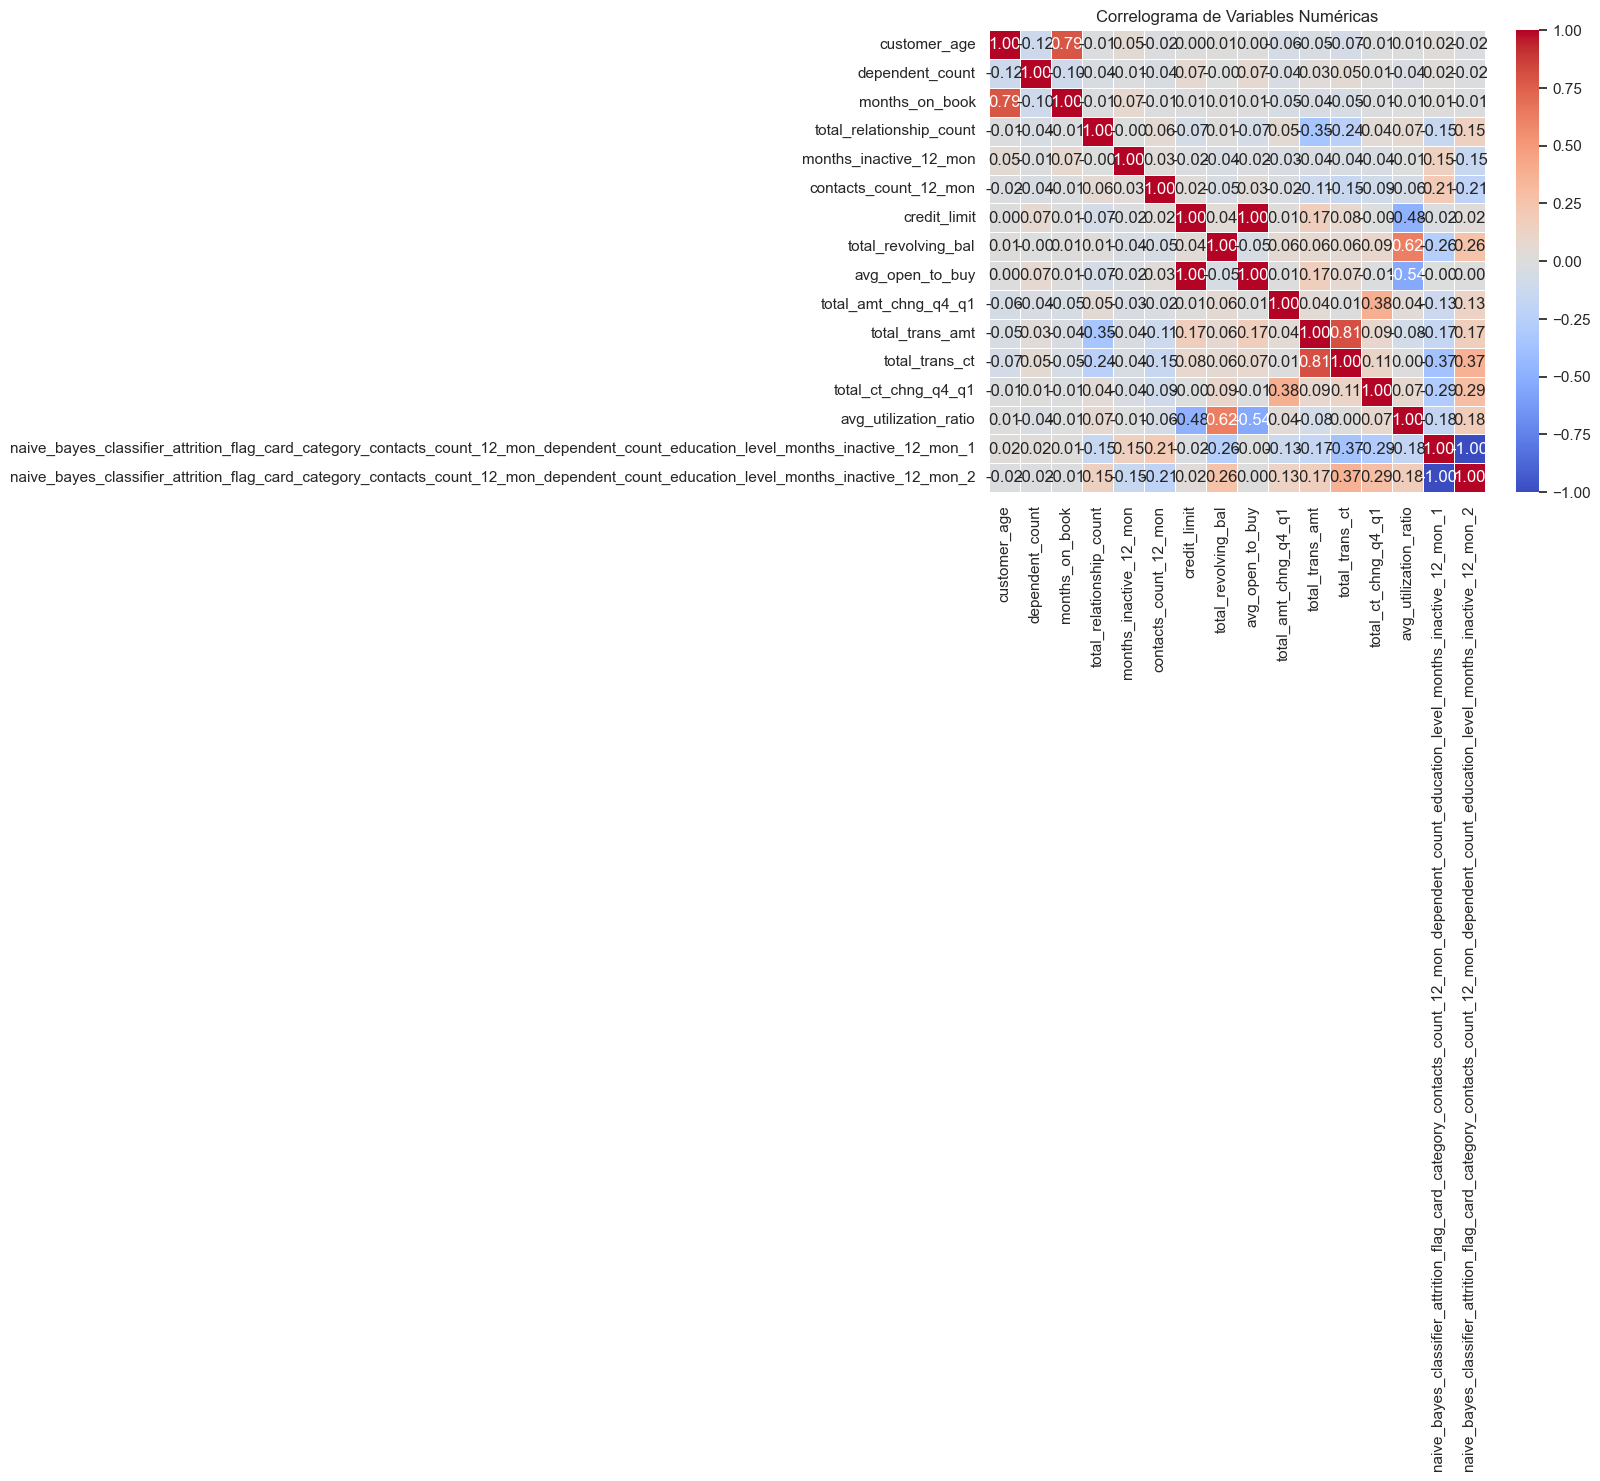

In [107]:
# Check Correlacion entre variables numericas
matriz_de_correlacion = data.corr()

sns.set(style="white")
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_de_correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlograma de Variables Numéricas')

plt.show()

Al identificar que las variables aportan la misma información, se opta por remover una de ellas.

In [108]:
# La correlacion entre el las columnas del modelo de Naive Bayes 1 y 2 es de 1
# Las variables aportan la misma informacion
# Se opta por Eliminar la segunda columna
data = data.drop(["naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2"], axis = 1)

# Renombrar columna restante del Modelo de Naive Bayes

data = data.rename(columns={"naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1": "naive_bayes_attrition_classifier"})



In [50]:
# Check distribucion de valores numericos
data.describe()

,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,naive_bayes_attrition_classifier
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894,0.159997
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691,0.365301
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000,0.000008
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000,0.000099
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000,0.000181
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000,0.000337
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000,0.999580


Se confirma que la presencia de outliers no sea significativa

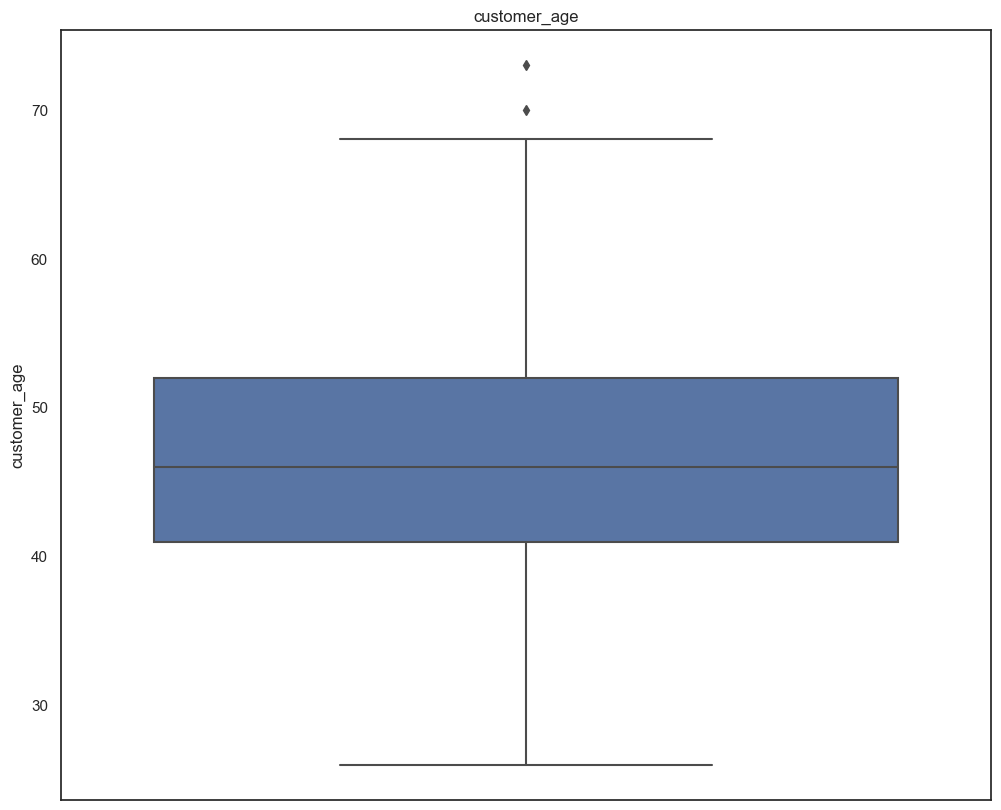

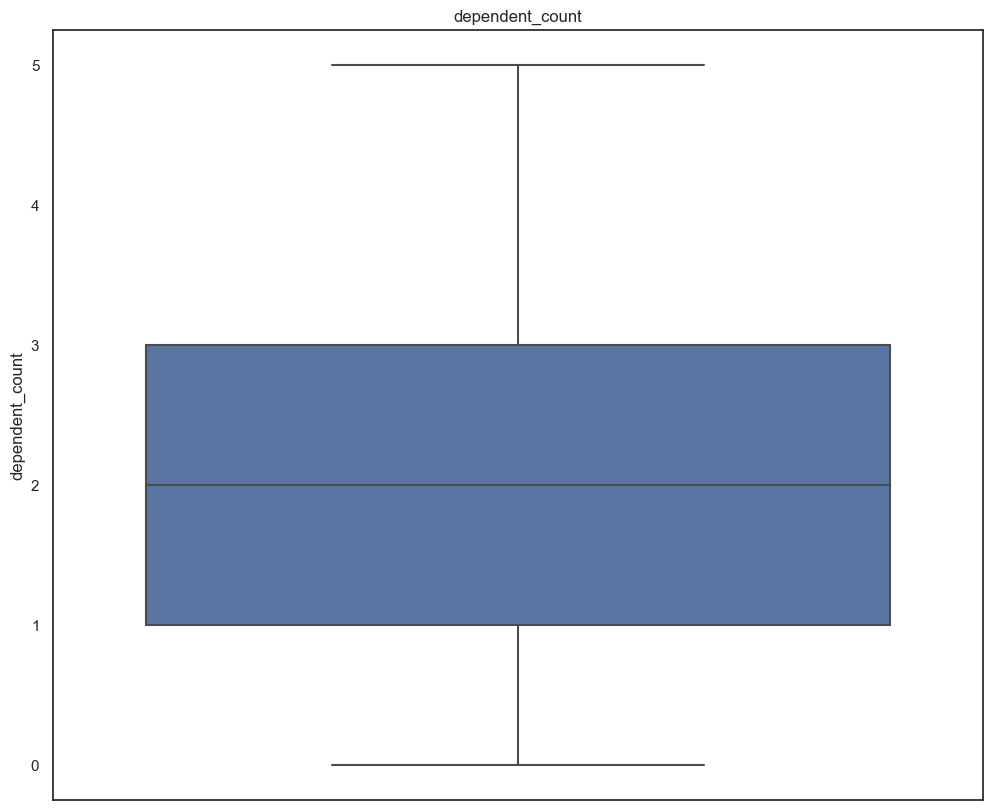

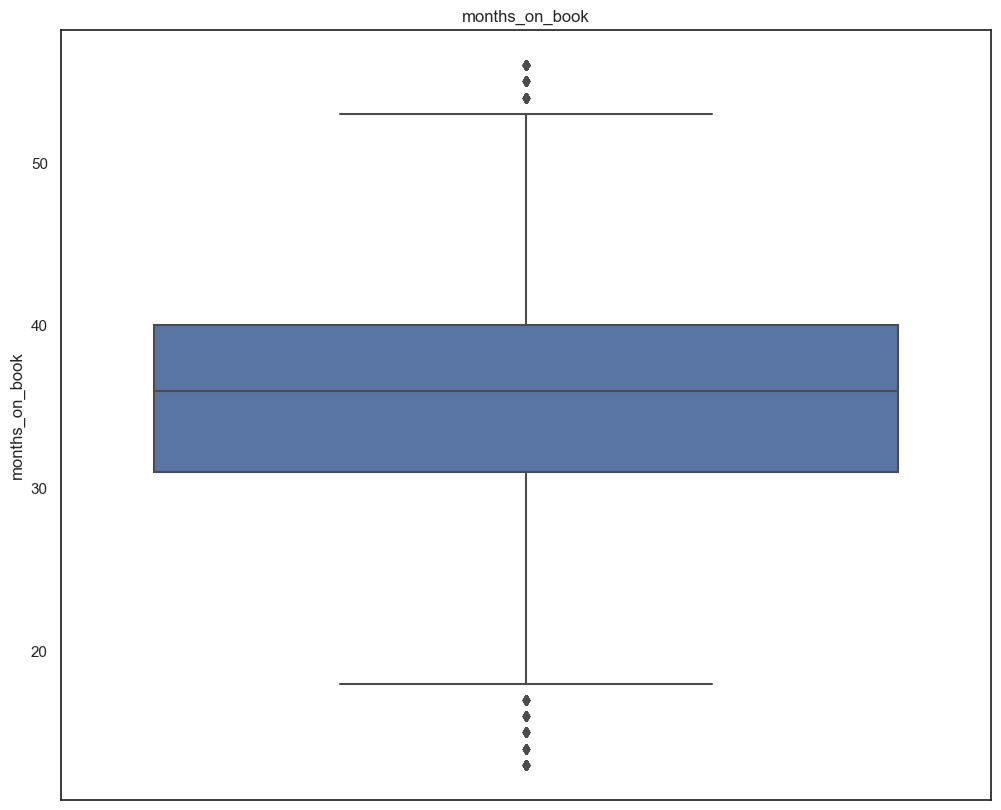

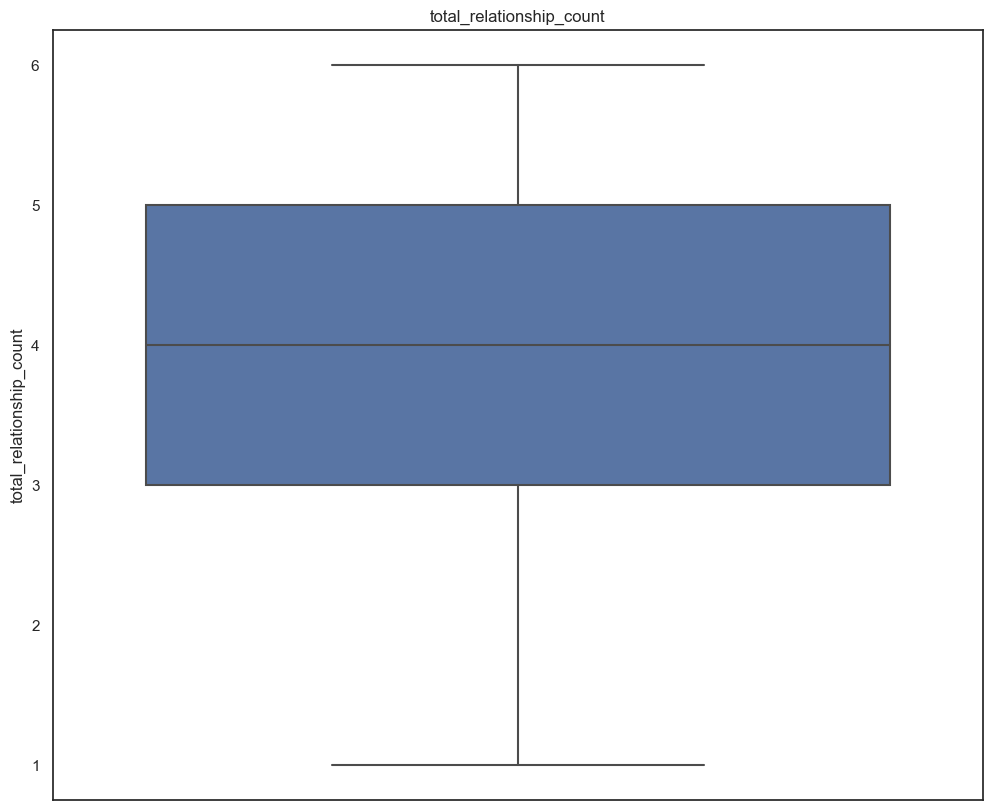

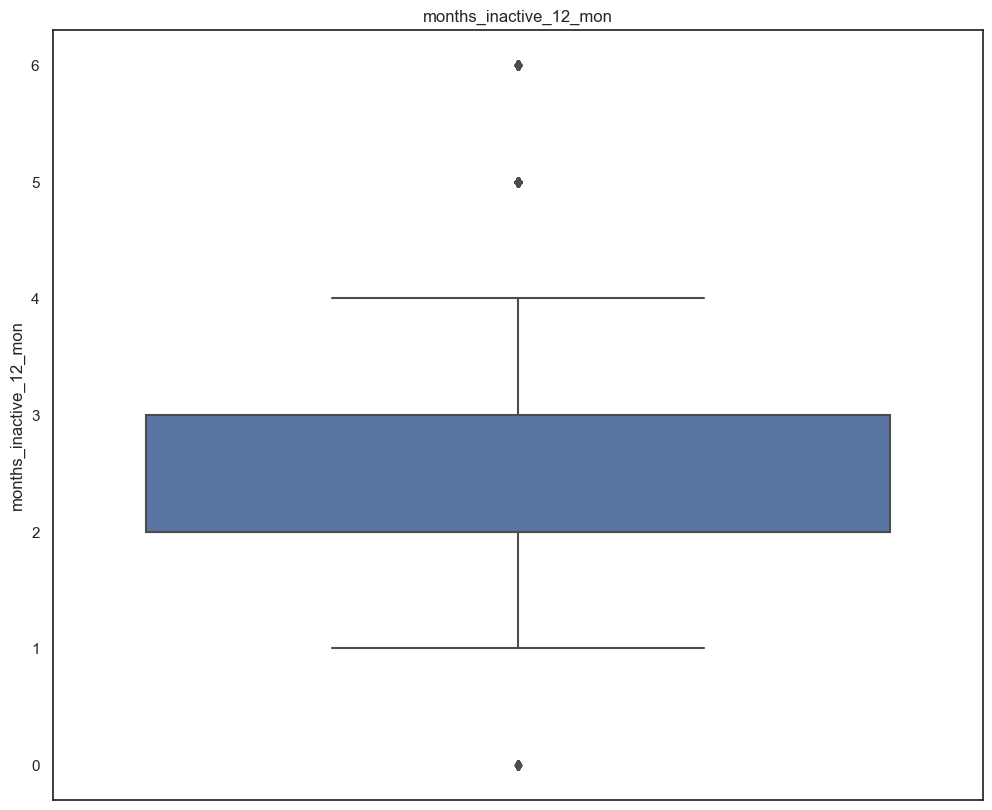

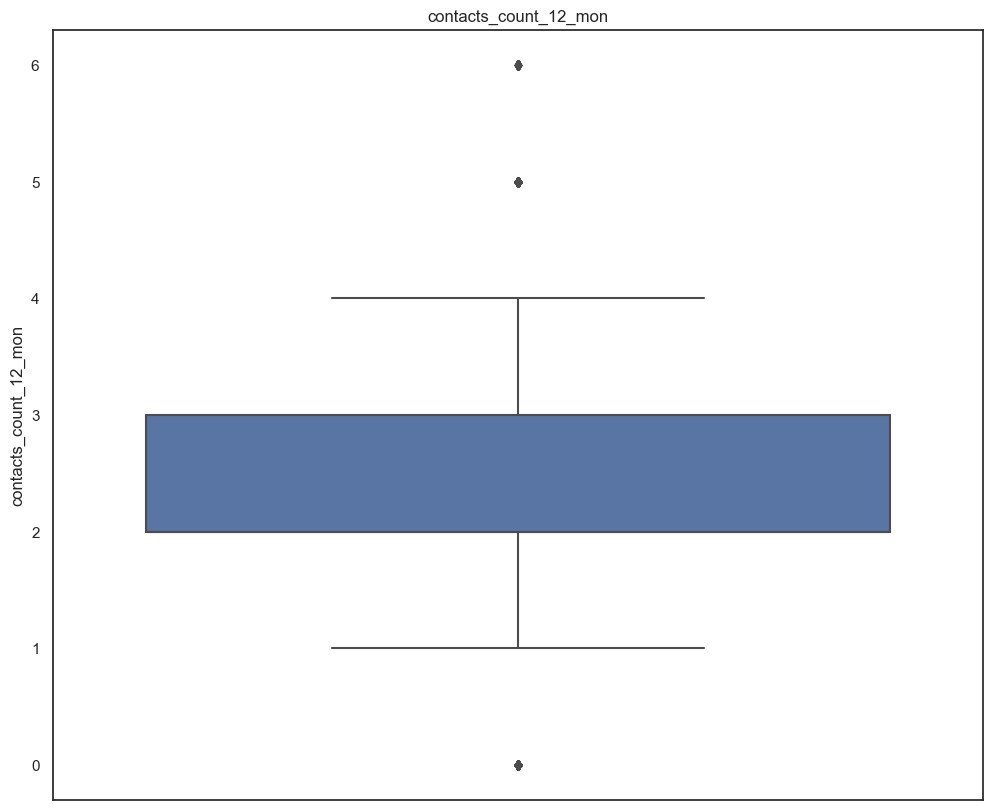

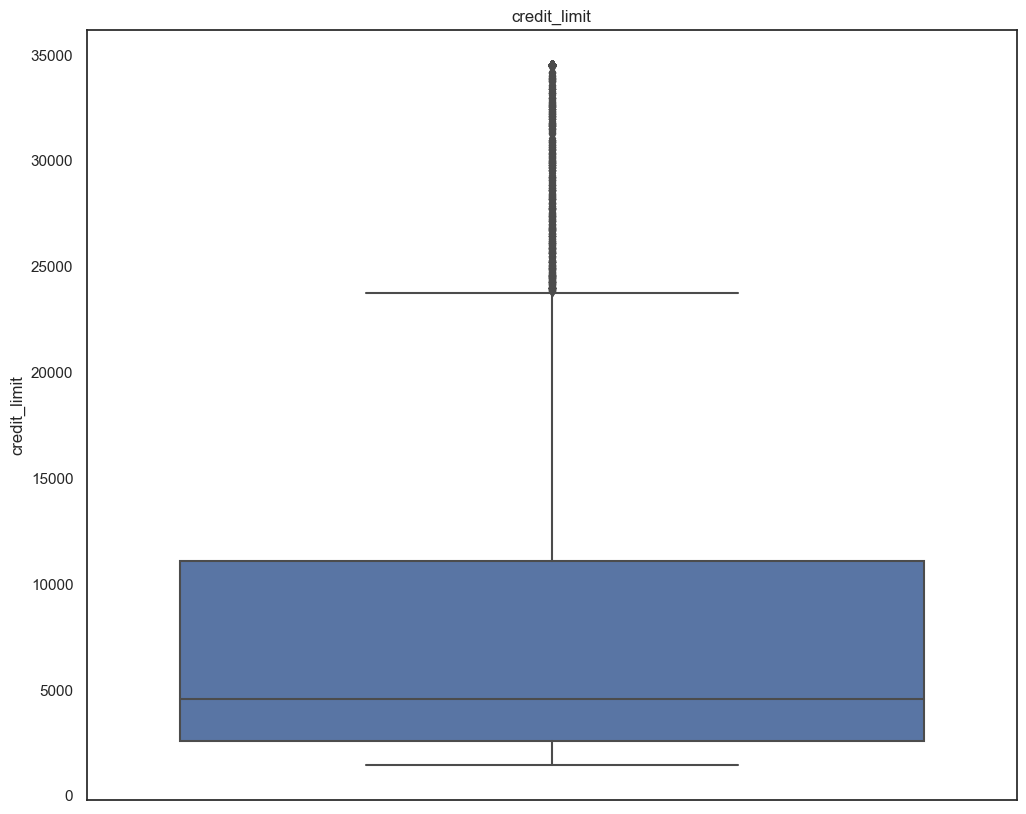

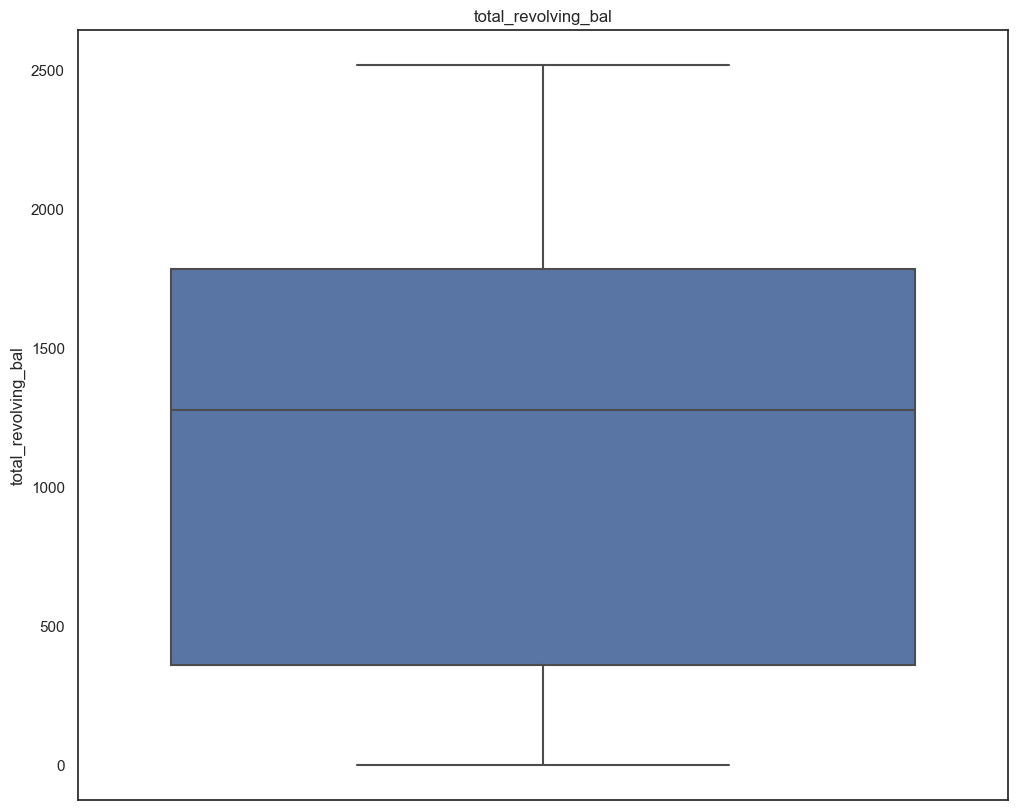

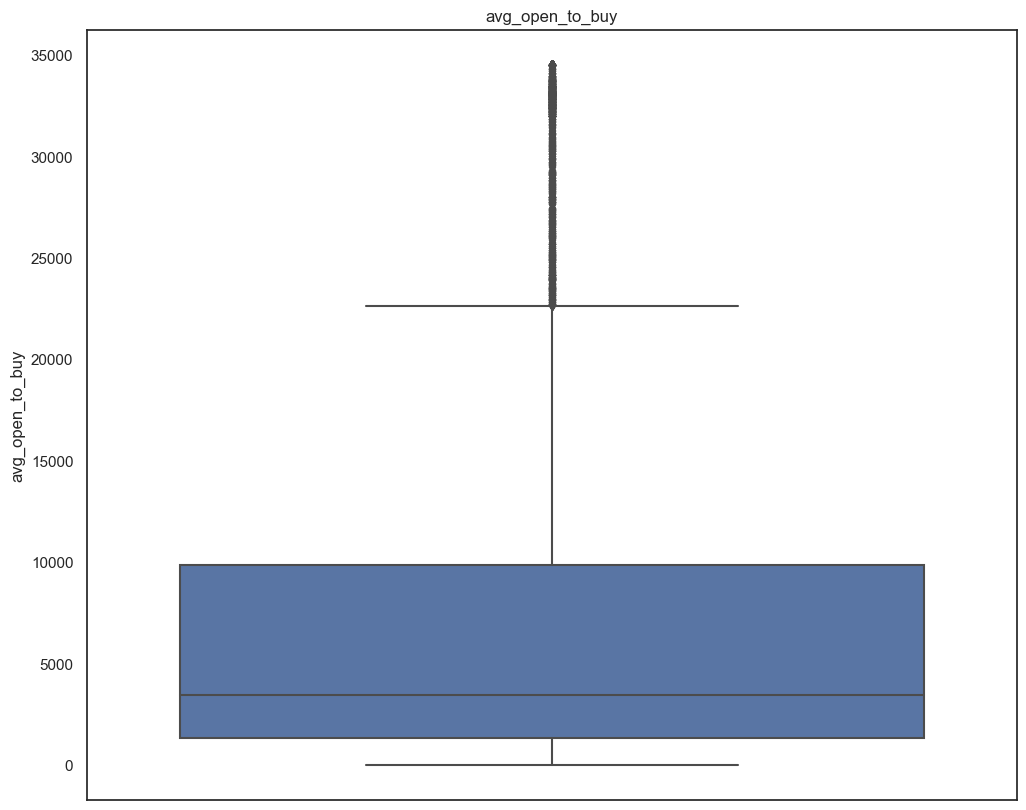

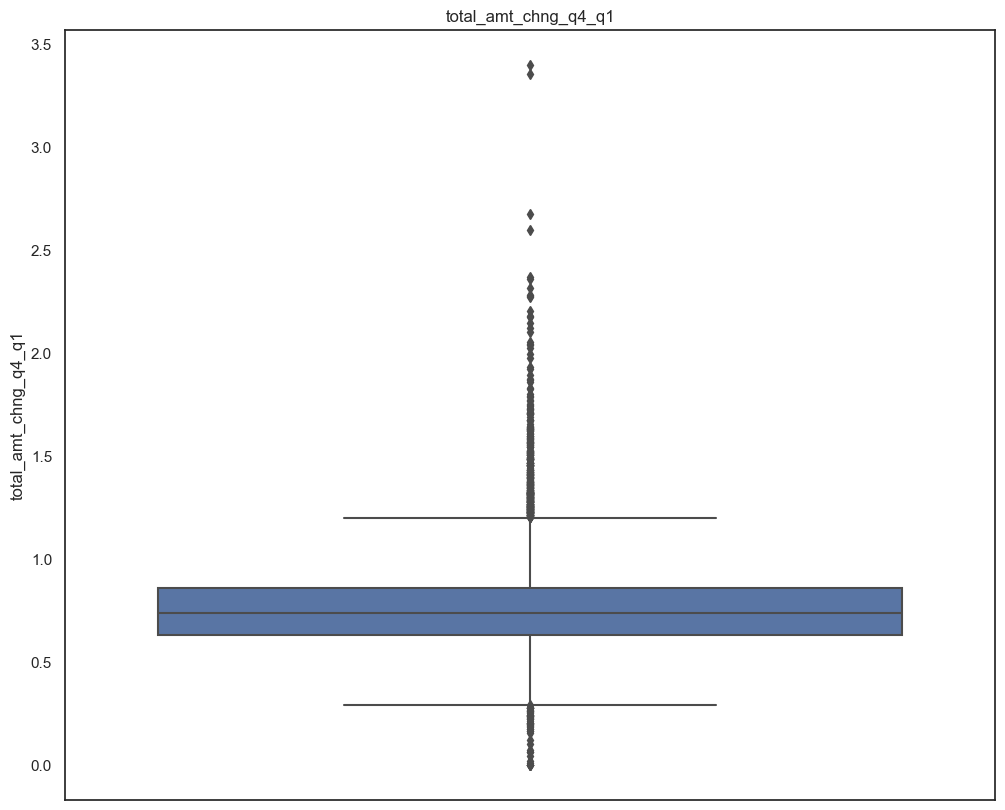

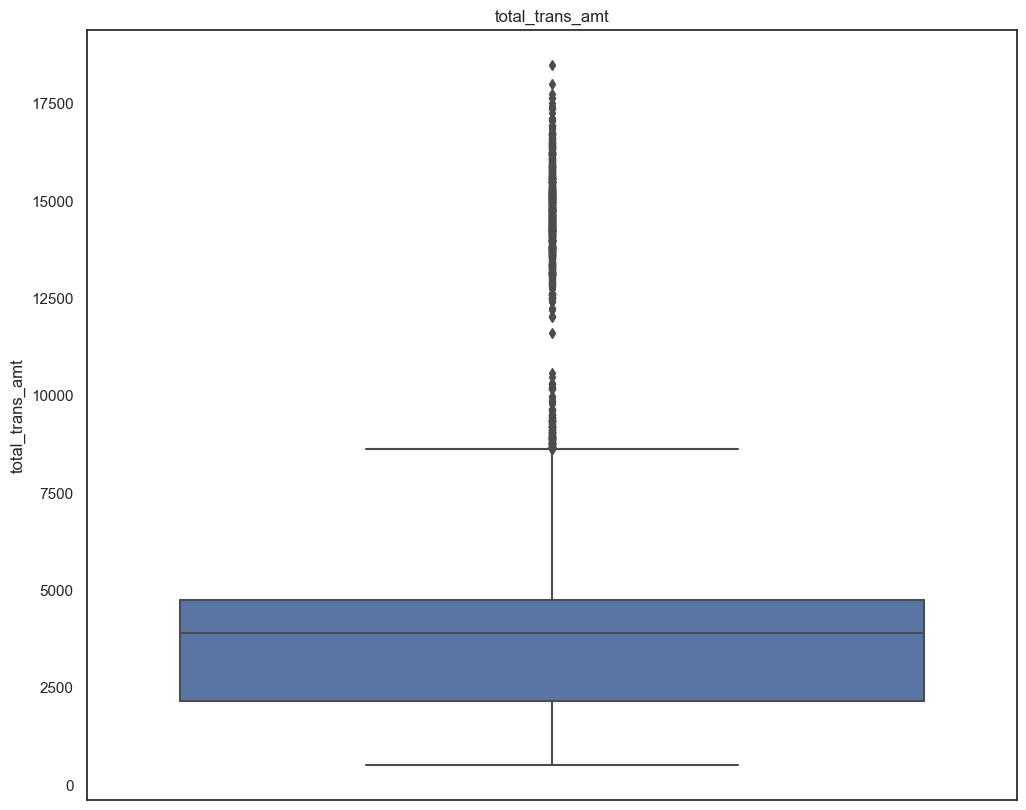

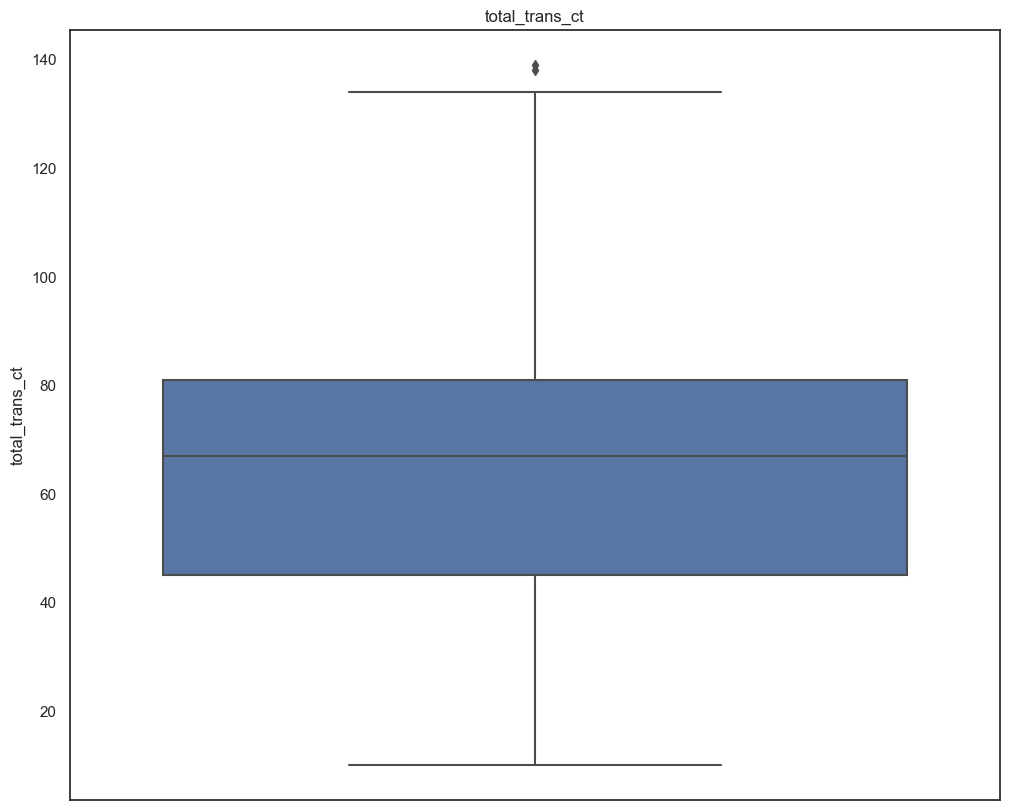

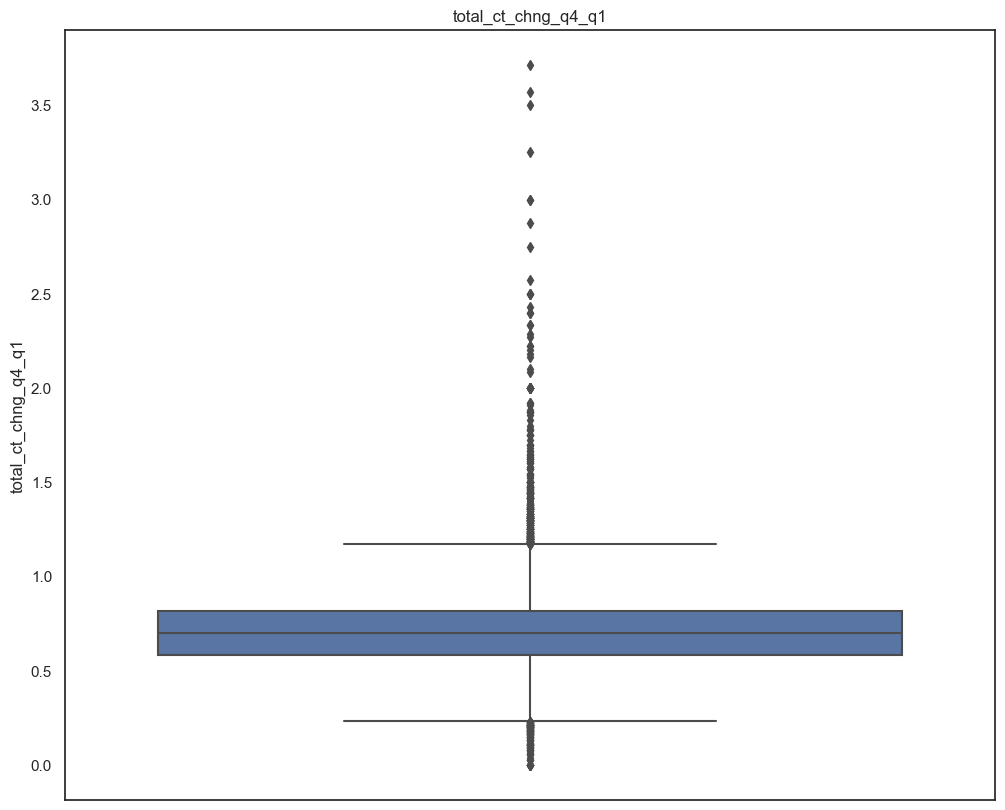

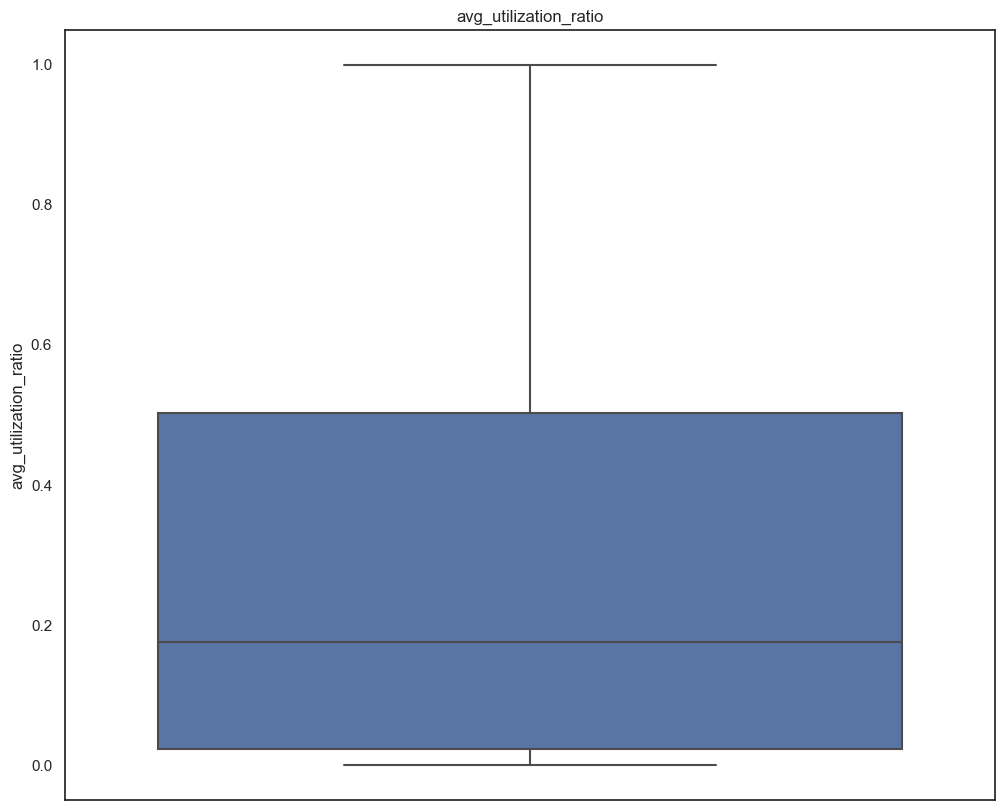

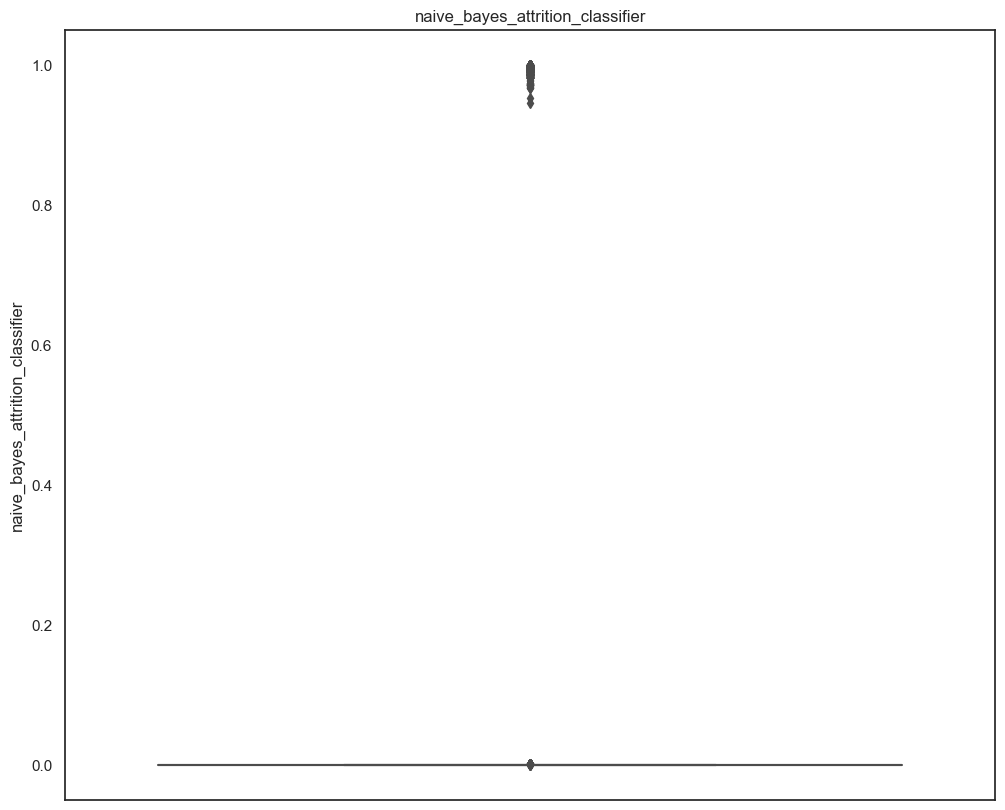

In [51]:
for column in data.select_dtypes(include=['number']).columns:
    plt.figure()  
    sns.boxplot(y = data[column])
    plt.title(column)  
    plt.xlabel('')  

plt.show() 

Al discretizar la variable del modelo Naive Bayes a 1 si se encuentra arriba de 0.5 y 0 si no, se encuentra una correlación de 1 con la variable objetivo. 


Se decide eliminar esta variable del modelo.Para nuestro caso de uso, donde el objetivo es contrastar arquitecturas de redes neuronales, mantener esta variable en el modelo es contraproducente ya que va explicar el modelo en un 100% en cualquier caso.  

In [109]:
# Discretizar variable naive_bayes_attrition_classifier como boolean
# 1 > 0.5 else 0
data["naive_bayes_attrition_classifier"] = data["naive_bayes_attrition_classifier"].apply(lambda x : 1 if x > 0.5 else 0)

# Convertir a Catgoria
data['naive_bayes_attrition_classifier'] = data['naive_bayes_attrition_classifier'].astype(str)


# Check distribucion de la variable
print(data['naive_bayes_attrition_classifier'].value_counts()/ len(data))


0    0.83934
1    0.16066
Name: naive_bayes_attrition_classifier, dtype: float64


In [110]:
# Estas variables estan aportando exactamente la misma informacion
data[['naive_bayes_attrition_classifier',"attrition_flag"]].head(20)

,naive_bayes_attrition_classifier,attrition_flag
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
5,0,1
6,0,1
7,0,1
8,0,1
9,0,1


In [111]:
# Se opta por remover la variable de Naive Bayes del modelo, ya que al no tener conocimiento del modelo utilizado de todas formas no se puede recrear para futuras implementaciones
print(sum(data['naive_bayes_attrition_classifier'] != data['attrition_flag']))

data = data.drop(['naive_bayes_attrition_classifier'], axis = 1)

10127


Al indetificar categorias Unknown en diferentes columnas, se imputa con la moda. 

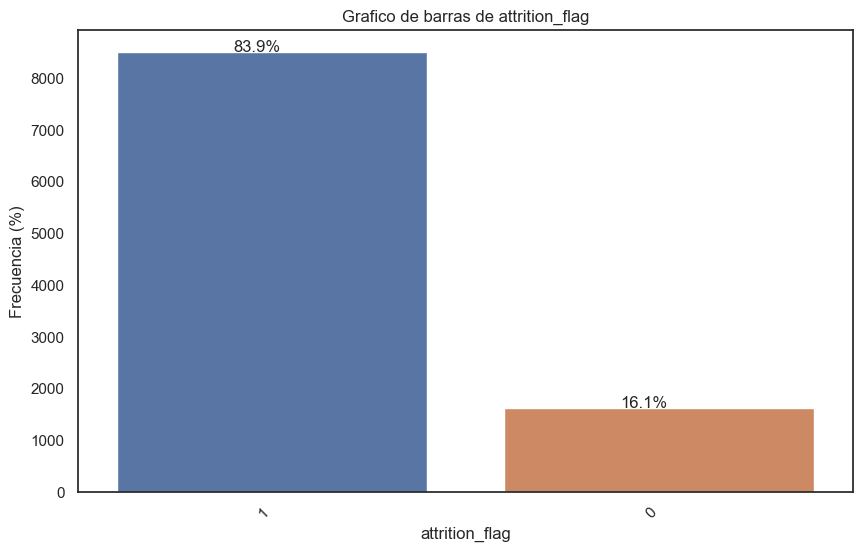

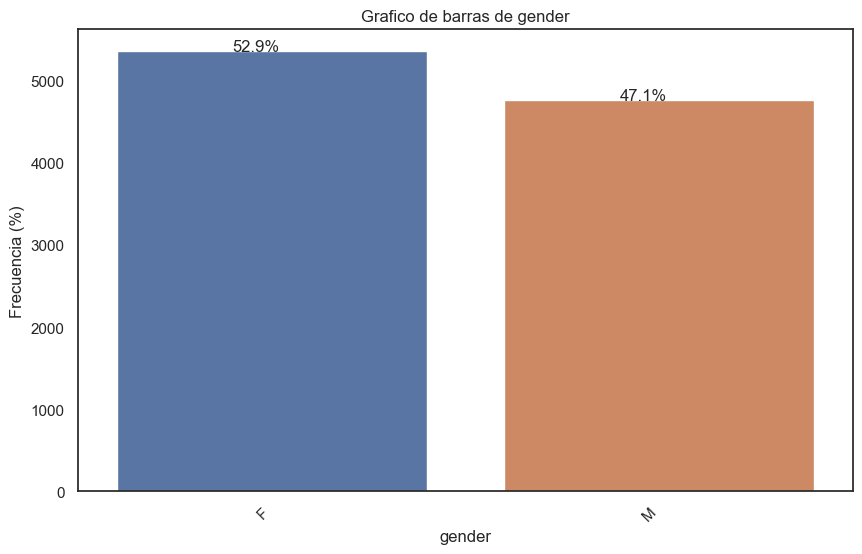

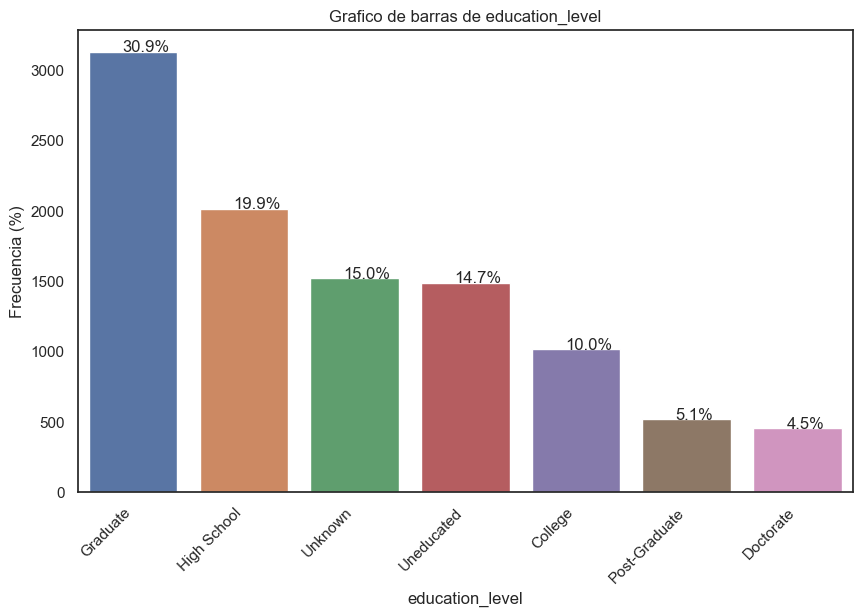

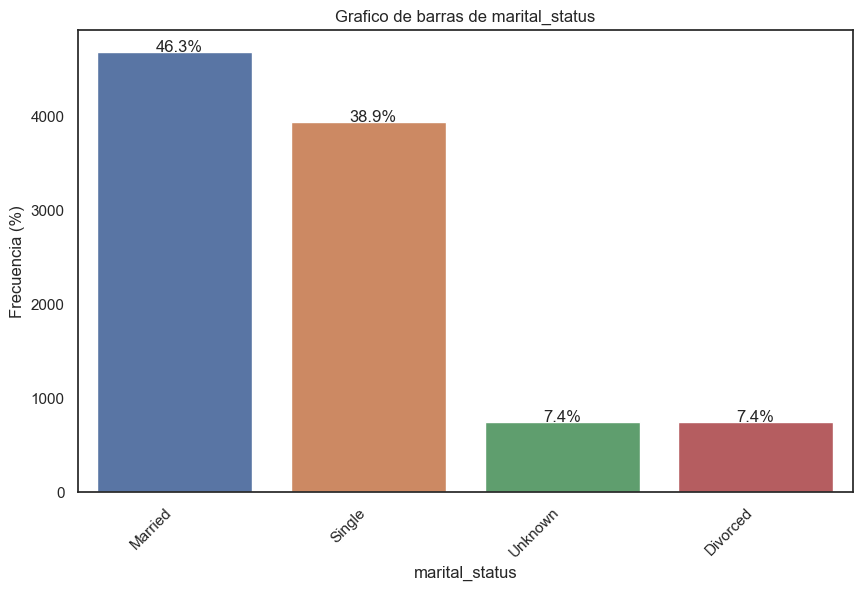

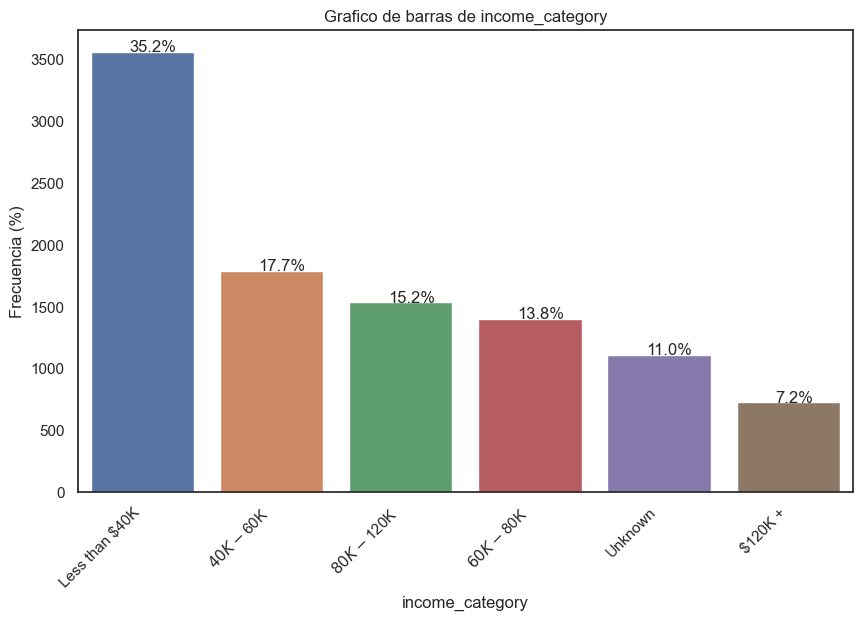

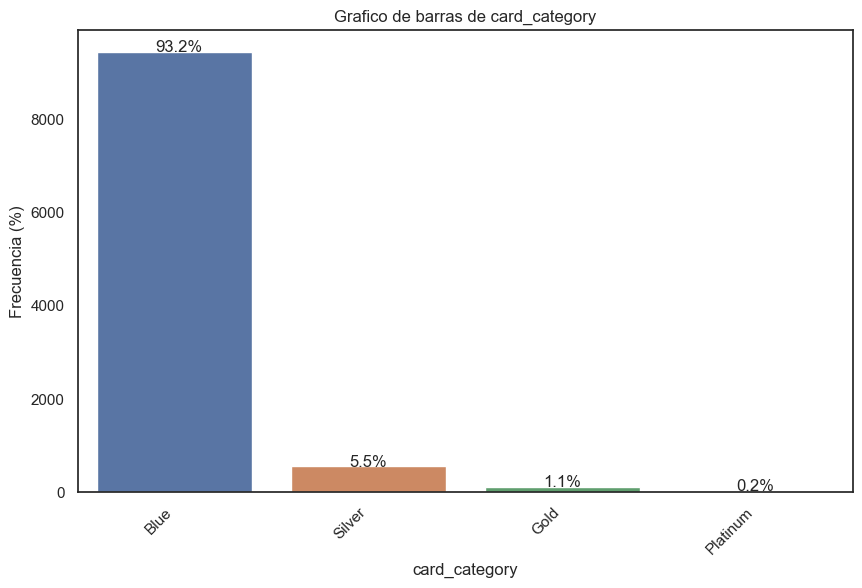

In [112]:
columnas_categoricas = data.select_dtypes(include=['object']).columns.tolist()

for column in columnas_categoricas:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, data = data, order = data[column].value_counts().index)
    plt.title(f'Grafico de barras de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia (%)')
    plt.xticks(rotation=45, ha='right')
    
    # Calculate percentage frequencies
    total_count = len(data[column])
    for p in plt.gca().patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)
        x = p.get_x() + p.get_width() / 2 - 0.1
        y = p.get_height()
        plt.gca().annotate(percentage, (x, y), size = 12)
    
    plt.show()

In [113]:
# Limpiar datos faltantes con la Moda

data = replace_unknown_with_mode(data, 'education_level')
data = replace_unknown_with_mode(data, 'marital_status')
data = replace_unknown_with_mode(data, 'income_category')


Las variables Categoricas Ordinales se pasan a númericas, así el modelo puede hacer uso de su información ordinal.

In [114]:
# Convertir columnas categoricas Ordinales a numericas

# Educational Level
nivel_educacion_map = {
    'Uneducated': 0,
    'High School': 1,
    'College': 2,
    'Graduate': 3,
    'Post-Graduate': 4,
    'Doctorate': 5
}

data['education_level'] = data['education_level'].map(nivel_educacion_map)


# income_category
income_category_map = {
    'Less than $40K': 0,
    '$40K - $60K': 1,
    '$60K - $80K': 2,
    '$80K - $120K': 3,
    '$120K +': 4
}

data['income_category'] = data['income_category'].map(income_category_map)

# card_category
card_category_map = {
    
    'Blue': 0,
    'Silver': 1,
    'Gold': 2,
    'Platinum': 3
}

data['card_category'] = data['card_category'].map(card_category_map)


raw_data = data.copy()

### 03 - Prepare Data for modelling

In [58]:
data.head()

,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
0,1,45,M,3,1,Married,2,0,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,1,49,F,5,3,Single,0,0,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,1,51,M,3,3,Married,3,0,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,1,40,F,4,1,Married,0,0,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,1,40,M,3,0,Married,2,0,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [89]:
# Normalizar columnas numericas
columnas_a_normalizar = data.select_dtypes(include=['number']).columns

for col_name in columnas_a_normalizar:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(data[col_name].values.reshape(-1, 1))
    data[col_name] = scaler.transform(data[col_name].values.reshape(-1, 1))
    

In [90]:
# Pasar a dummy las variables categoricas

dummed_features = []

for col_name in data.columns:
    
    if(data[col_name].dtype == 'object' and col_name != 'attrition_flag'):
        j = pd.get_dummies(data[col_name], dtype=int)
        data = pd.concat([data, j], axis=1)
        dummed_features.append(col_name)

# remove all transformed features
data = data[data.columns.difference(dummed_features)]


In [27]:
data.head()

,Divorced,F,M,Married,Single,attrition_flag,avg_open_to_buy,avg_utilization_ratio,card_category,contacts_count_12_mon,...,education_level,income_category,months_inactive_12_mon,months_on_book,total_amt_chng_q4_q1,total_ct_chng_q4_q1,total_relationship_count,total_revolving_bal,total_trans_amt,total_trans_ct
0,0,0,1,1,0,1,0.345116,0.061061,0.0,0.500000,...,0.2,0.50,0.166667,0.604651,0.392994,0.437534,0.8,0.308701,0.035273,0.248062
1,0,1,0,0,1,1,0.214093,0.105105,0.0,0.333333,...,0.6,0.00,0.166667,0.720930,0.453636,1.000000,1.0,0.343266,0.043452,0.178295
2,0,0,1,1,0,1,0.098948,0.000000,0.0,0.000000,...,0.6,0.75,0.166667,0.534884,0.763615,0.628164,0.6,0.000000,0.076611,0.077519
3,0,1,0,1,0,1,0.022977,0.760761,0.0,0.166667,...,0.2,0.00,0.666667,0.488372,0.413600,0.628164,0.4,1.000000,0.036775,0.077519
4,0,0,1,1,0,1,0.136557,0.000000,0.0,0.000000,...,0.0,0.50,0.166667,0.186047,0.640271,0.673129,0.8,0.000000,0.017025,0.139535


In [91]:
data['attrition_flag'] = data['attrition_flag'].astype(int)

In [92]:
# Separar data en train y test

train_df, test_df = train_test_split(data, test_size = 0.25, random_state = 0)

train_df, val_df = train_test_split(train_df, test_size = 0.25, random_state = 0)

In [93]:
target = "attrition_flag"

# Extraer X
train_features = np.array(train_df[train_df.columns.difference([target])])
val_features = np.array(val_df[val_df.columns.difference([target])])
test_features = np.array(test_df[test_df.columns.difference([target])])

# Extraer Y
train_labels = np.array(train_df[[target]])
val_labels = np.array(val_df[[target]])
test_labels = np.array(test_df[[target]])


In [94]:
# Definir variable utiles para la red neuronal
units = train_features.shape[1] # Número de neuronas
input_dim = train_features.shape[1] # Dimensión de la data de entrada

### 04 - Create First Architecture

La primera arquitectura ha desarrollar tiene la siguiente estructura:

    1. Un modelo secuencial, formado por 1 capa de entrada, N capas ocultas, una capa de salida.
    2. Todas la capas ocultas con 22 neuronas, función de activación RELU, inicializador kernel normal y un dropout d.
    3. La capa de salida con 2 neuronas, función de activación softmax, e inicilizador kernel uniforme
    4. Se utiliza el optimizador de Adam.
    5. Como función de perdida se utiliza sparse_categorical_crossentropy
    6. Como métrica de despeño se utiliza el accuracy
    7. El modelo es entrenado con 100 Epochs
    
 
 Se Optimizan los siguientes parámetros con los rangos correspondientes:
     
     * Capas (dense_layers) = [2, 4, 6]
     * Batch Size (batch_size) = [128, 256, 384]
     * Dropout (dense_dropout) = [0, 0.05, 0.1]

Se procede con la optimización de capas intermedias de la primera arquitectura

C:\Users\alexs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


dense_layers :2
batch_size :128
dense_dropout :0.0


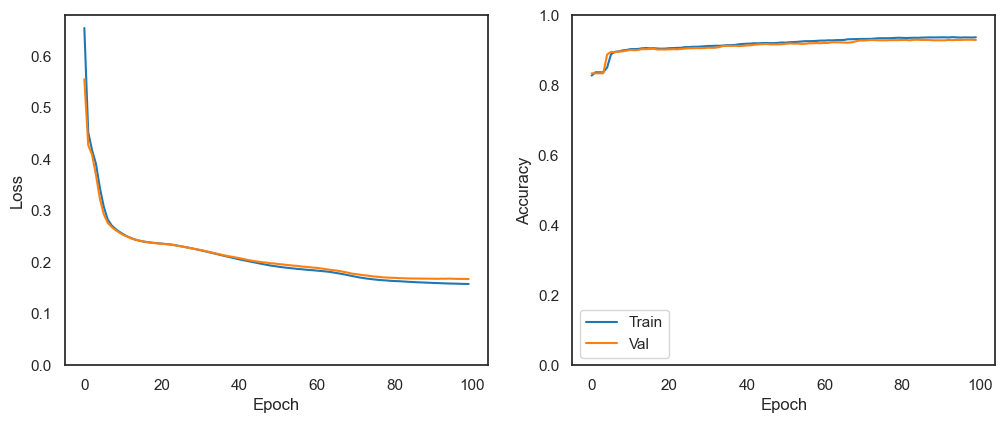

C:\Users\alexs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


dense_layers :4
batch_size :128
dense_dropout :0.0


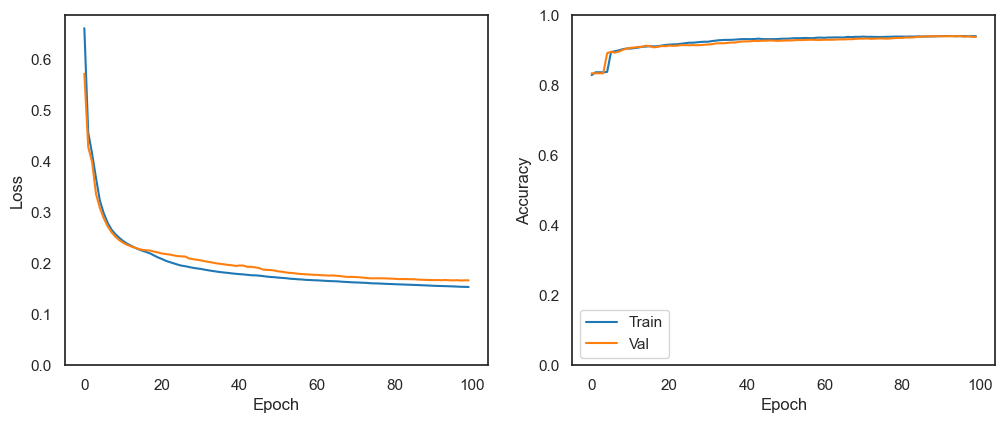

C:\Users\alexs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


dense_layers :6
batch_size :128
dense_dropout :0.0


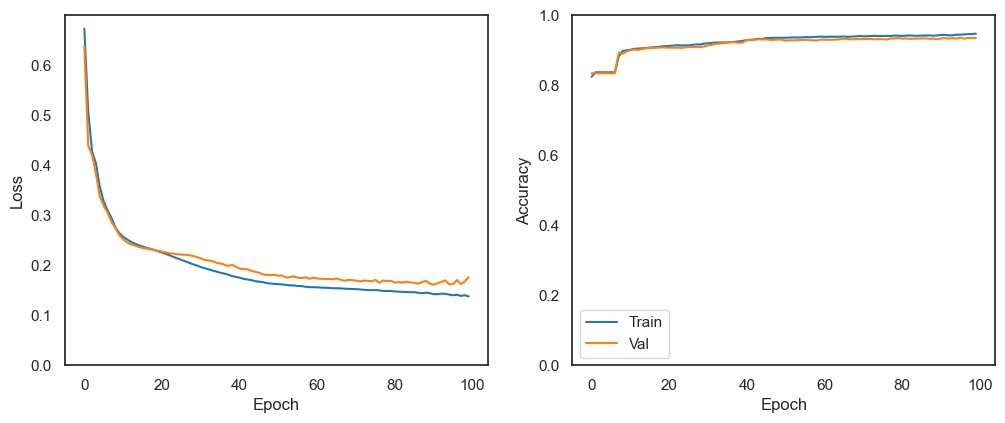

In [74]:
# Grid Search

epochs = [100]
batch_size = [128]
dense_layers = [2, 4, 6]
dense_dropout = [0.0]


param_grid = dict(dense_layers = dense_layers,
                  batch_size = batch_size,
                  epochs = epochs,
                  dense_dropout = dense_dropout)

keys = param_grid.keys()
values = (param_grid[key] for key in keys)
param_grid = [dict(zip(keys, param_grid)) for param_grid in itertools.product(*values)]

for j in range(0, len(param_grid)):
    
    dense_layers = param_grid[j].get("dense_layers")
    batch_size = param_grid[j].get("batch_size")
    dense_dropout = param_grid[j].get("dense_dropout")
    epochs = param_grid[j].get("epochs")
    
    model = make_model_1(units = units,
                         input_dim = input_dim,
                         dense_layers = dense_layers,
                         dense_dropout = dense_dropout)
    
    print('dense_layers :' + str(dense_layers))
    print('batch_size :' + str(batch_size))
    print('dense_dropout :' + str(dense_dropout))
    
    history = model.fit(train_features,
                    train_labels,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_data = (val_features, val_labels), 
                    verbose = 0)
    
    
    plot_history(history)
    
    val_accuracy = pd.DataFrame.from_dict(history.history)['val_accuracy'].iloc[-1]
    val_accuracy = pd.DataFrame.from_dict(history.history)['accuracy'].iloc[-1]
    param_grid[j].update( {"val_accuracy" : val_accuracy})
    param_grid[j].update( {"val_accuracy" : val_accuracy})
    
results = pd.DataFrame(param_grid)

En general se tiene un buen desempeño inicial, con un accuracy mayor a 93% en todos los casos. Se puede observar como el aumento en capas intermedias causa el aumento del accuracy en el set de entrenamiento y validación. Sin embargo, a pesar de que la función de perdida también mejora para un número mayor de capas intermedias, el set de validación y el set de entrenamiento comienzan a difererir, siento el set de validación peor que el de entrenamiento, en cuanto mayor capas peor.

Por lo tanto, para sopesar por esto y evitar el sobreajuste, se decide escoger 4 capas, a pesar que el modelo de 6 capas tiene mejor accuracy. 

In [75]:
results.sort_values(by=['val_accuracy'], ascending=False)

,dense_layers,batch_size,epochs,dense_dropout,val_accuracy
2,6,128,100,0.0,0.947683
1,4,128,100,0.0,0.940133
0,2,128,100,0.0,0.936973


Ahora optimizamos para el batch size.

C:\Users\alexs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


dense_layers :4
batch_size :128
dense_dropout :0.0


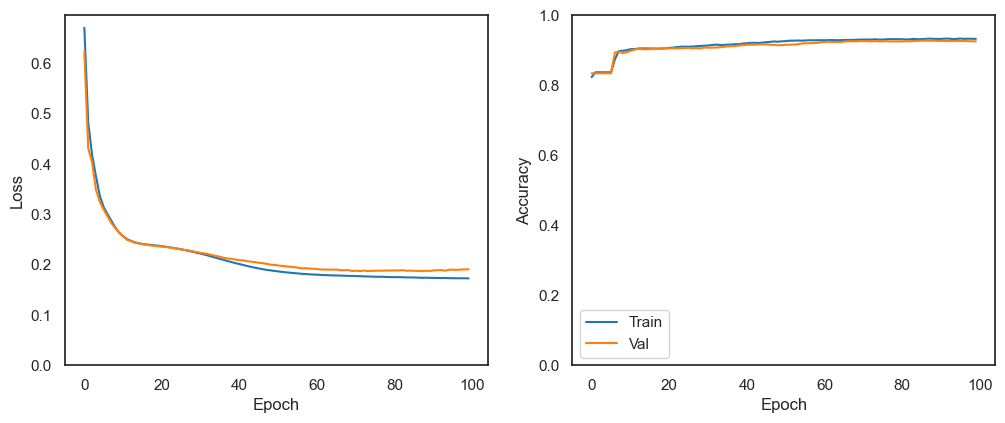

C:\Users\alexs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


dense_layers :4
batch_size :256
dense_dropout :0.0


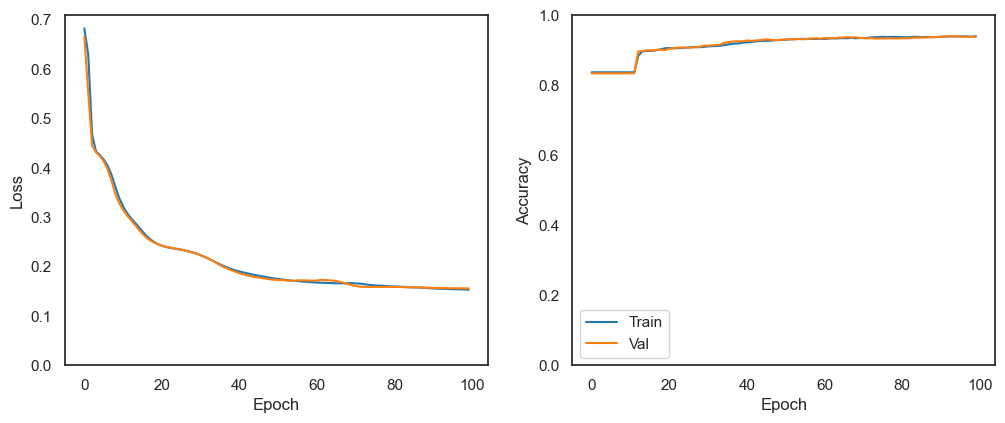

C:\Users\alexs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


dense_layers :4
batch_size :384
dense_dropout :0.0


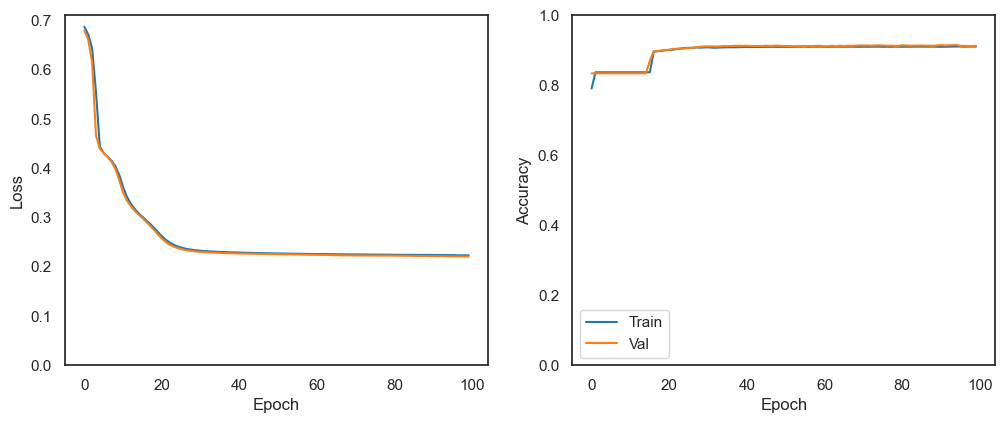

In [76]:
# Grid Search

epochs = [100]
batch_size = [128, 256, 384]
dense_layers = [4]
dense_dropout = [0.0]


param_grid = dict(dense_layers = dense_layers,
                  batch_size = batch_size,
                  epochs = epochs,
                  dense_dropout = dense_dropout)

keys = param_grid.keys()
values = (param_grid[key] for key in keys)
param_grid = [dict(zip(keys, param_grid)) for param_grid in itertools.product(*values)]

for j in range(0, len(param_grid)):
    
    dense_layers = param_grid[j].get("dense_layers")
    batch_size = param_grid[j].get("batch_size")
    dense_dropout = param_grid[j].get("dense_dropout")
    epochs = param_grid[j].get("epochs")
    
    model = make_model_1(units = units,
                         input_dim = input_dim,
                         dense_layers = dense_layers,
                         dense_dropout = dense_dropout)
    
    print('dense_layers :' + str(dense_layers))
    print('batch_size :' + str(batch_size))
    print('dense_dropout :' + str(dense_dropout))
    
    history = model.fit(train_features,
                    train_labels,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_data = (val_features, val_labels), 
                    verbose = 0)
    
    
    plot_history(history)
    
    val_accuracy = pd.DataFrame.from_dict(history.history)['val_accuracy'].iloc[-1]
    val_accuracy = pd.DataFrame.from_dict(history.history)['accuracy'].iloc[-1]
    param_grid[j].update( {"val_accuracy" : val_accuracy})
    param_grid[j].update( {"val_accuracy" : val_accuracy})
    
results = pd.DataFrame(param_grid)

Ahora al optimizar por el batch size, se obtiene el mejor accuracy con un valor de 256. También se puede observar como al aumentar el batch size se evita el sobreajuste. 

In [77]:
results.sort_values(by=['val_accuracy'], ascending = False)

,dense_layers,batch_size,epochs,dense_dropout,val_accuracy
1,4,256,100,0.0,0.940133
0,4,128,100,0.0,0.932584
2,4,384,100,0.0,0.910464


Se realiza el gridsearch para el dropout. 

C:\Users\alexs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


dense_layers :4
batch_size :256
dense_dropout :0


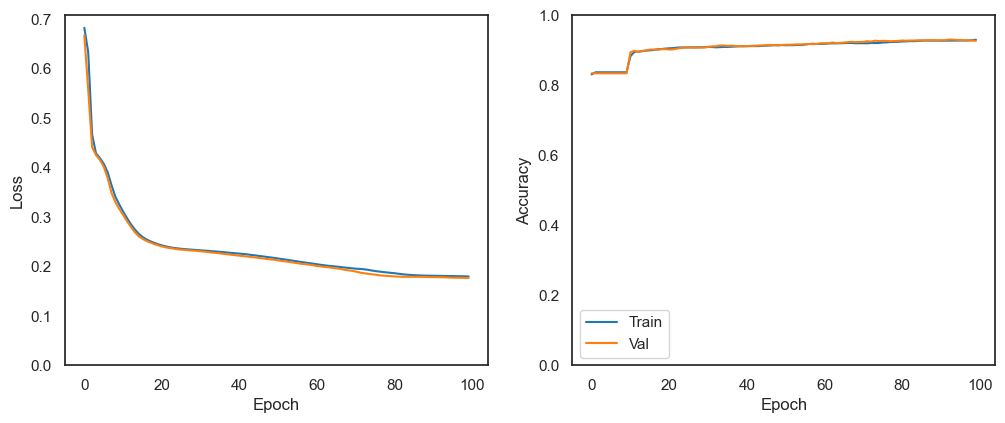

C:\Users\alexs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


dense_layers :4
batch_size :256
dense_dropout :0.05


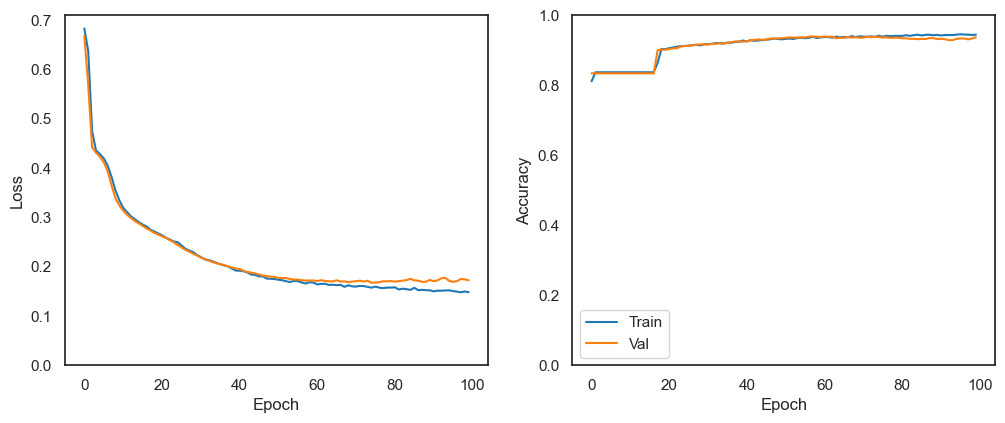

C:\Users\alexs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


dense_layers :4
batch_size :256
dense_dropout :0.1


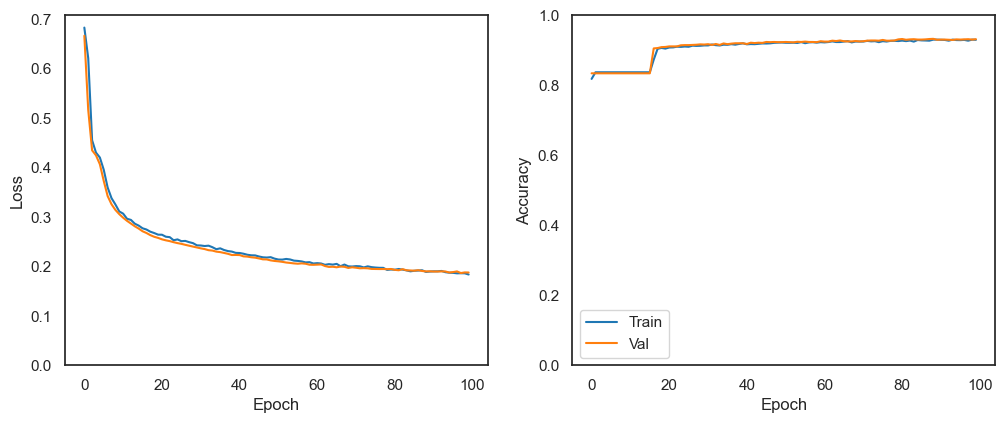

In [78]:
# Grid Search

epochs = [100]
batch_size = [256]
dense_layers = [4]
dense_dropout = [0, 0.05, 0.1]


param_grid = dict(dense_layers = dense_layers,
                  batch_size = batch_size,
                  epochs = epochs,
                  dense_dropout = dense_dropout)

keys = param_grid.keys()
values = (param_grid[key] for key in keys)
param_grid = [dict(zip(keys, param_grid)) for param_grid in itertools.product(*values)]

for j in range(0, len(param_grid)):
    
    dense_layers = param_grid[j].get("dense_layers")
    batch_size = param_grid[j].get("batch_size")
    dense_dropout = param_grid[j].get("dense_dropout")
    epochs = param_grid[j].get("epochs")
    
    model = make_model_1(units = units,
                         input_dim = input_dim,
                         dense_layers = dense_layers,
                         dense_dropout = dense_dropout)
    
    print('dense_layers :' + str(dense_layers))
    print('batch_size :' + str(batch_size))
    print('dense_dropout :' + str(dense_dropout))
    
    history = model.fit(train_features,
                    train_labels,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_data = (val_features, val_labels), 
                    verbose = 0)
    
    
    plot_history(history)
    
    val_accuracy = pd.DataFrame.from_dict(history.history)['val_accuracy'].iloc[-1]
    val_accuracy = pd.DataFrame.from_dict(history.history)['accuracy'].iloc[-1]
    param_grid[j].update( {"val_accuracy" : val_accuracy})
    param_grid[j].update( {"val_accuracy" : val_accuracy})
    
results = pd.DataFrame(param_grid)

Al optimizar por dropout se obtiene el mejor desempeño con un dropout de 0.05, obteniendo finalmente un desempeño de 94% de accuracy en el set de validación.

In [80]:
results.sort_values(by=['val_accuracy'], ascending = False)

,dense_layers,batch_size,epochs,dense_dropout,val_accuracy
1,4,256,100,0.05,0.944523
0,4,256,100,0.00,0.930126
2,4,256,100,0.10,0.929775


### 05 - Create Second Architecture

La segunda arquitectura ha desarrollar tiene la siguiente estructura:

    1. Un modelo secuencial, formado por 1 capa de entrada, N capas ocultas, una capa de salida.
    2. Todas la capas ocultas con 22 neuronas, función de activación RELU, inicializador kernel normal y sin dropout.
    3. La capa de salida con 2 neuronas, función de activación softmax, e inicilizador kernel uniforme, y dropout d.
    4. Se utiliza el optimizador de Adam.
    5. Como función de perdida se utiliza sparse_categorical_crossentropy
    6. Como métrica de despeño se utiliza el accuracy
    7. El modelo es entrenado con 100 Epochs
 
 Se Optimizan los siguientes parámetros con los rangos correspondientes:
     
     * Capas (dense_layers) = [2, 4, 6]
     * Batch Size (batch_size) = [128, 256, 384]
     * Dropout (dense_dropout) = [0, 0.05, 0.1]
     
 Esta arquitectura difiere con respecto a la arquitectura 1 fundamentalmente en la presencia del dropout. En este caso el dropout solmanete esta presente en la capa de salida.

In [81]:
units = train_features.shape[1]
input_dim = train_features.shape[1]

En primer lugar se realiza el gridsearch sobre la cantidad de capas intermedias.

C:\Users\alexs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


dense_layers :2
batch_size :128
dense_dropout :0.0


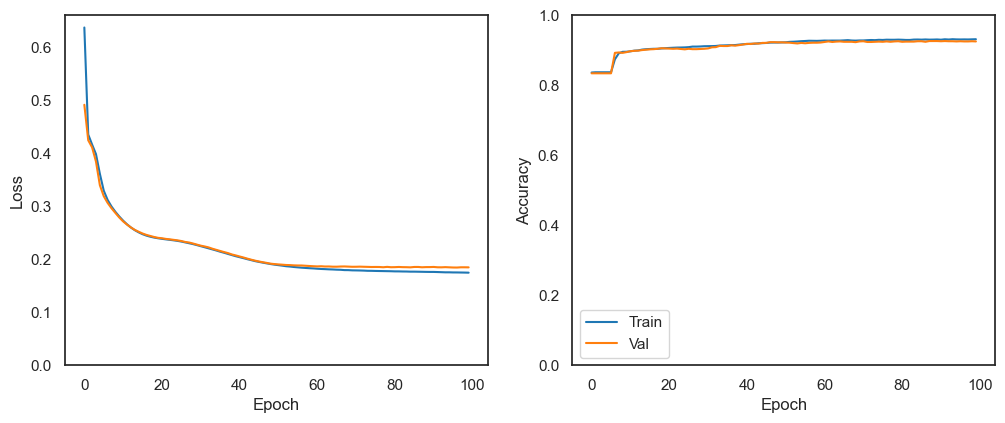

C:\Users\alexs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


dense_layers :4
batch_size :128
dense_dropout :0.0


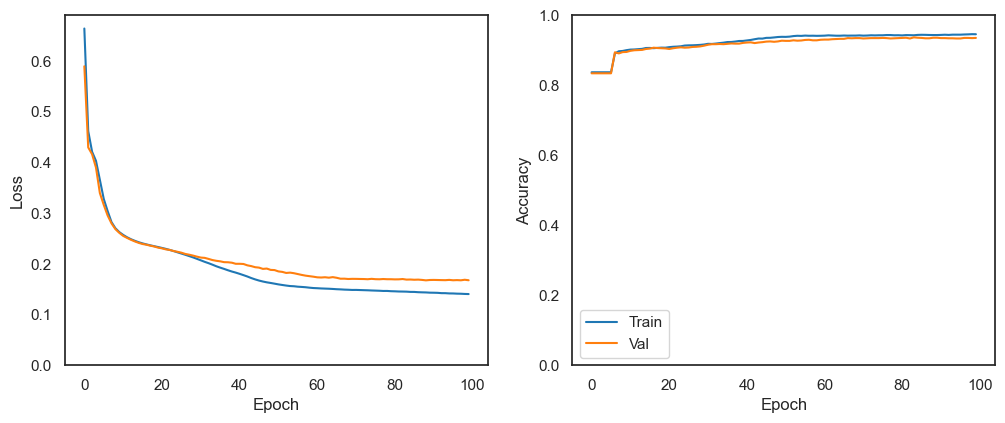

C:\Users\alexs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


dense_layers :6
batch_size :128
dense_dropout :0.0


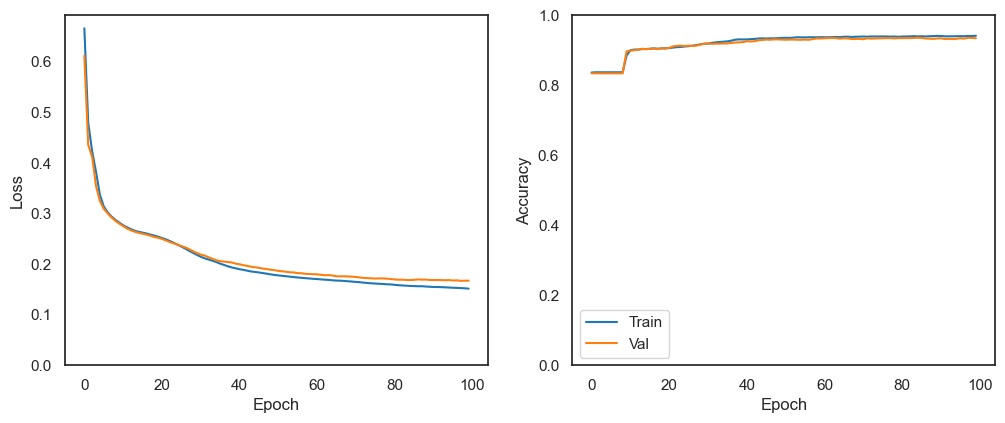

In [82]:
# Grid Search

epochs = [100]
batch_size = [128]
dense_layers = [2, 4, 6]
dense_dropout = [0.0]


param_grid = dict(dense_layers = dense_layers,
                  batch_size = batch_size,
                  epochs = epochs,
                  dense_dropout = dense_dropout)

keys = param_grid.keys()
values = (param_grid[key] for key in keys)
param_grid = [dict(zip(keys, param_grid)) for param_grid in itertools.product(*values)]

for j in range(0, len(param_grid)):
    
    dense_layers = param_grid[j].get("dense_layers")
    batch_size = param_grid[j].get("batch_size")
    dense_dropout = param_grid[j].get("dense_dropout")
    epochs = param_grid[j].get("epochs")
    
    model = make_model_2(units = units,
                         input_dim = input_dim,
                         dense_layers = dense_layers,
                         dense_dropout = dense_dropout)
    
    print('dense_layers :' + str(dense_layers))
    print('batch_size :' + str(batch_size))
    print('dense_dropout :' + str(dense_dropout))
    
    history = model.fit(train_features,
                    train_labels,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_data = (val_features, val_labels),
                    verbose = 0)
    
    
    plot_history(history)
    
    val_accuracy = pd.DataFrame.from_dict(history.history)['val_accuracy'].iloc[-1]
    val_accuracy = pd.DataFrame.from_dict(history.history)['accuracy'].iloc[-1]
    param_grid[j].update( {"val_accuracy" : val_accuracy})
    param_grid[j].update( {"val_accuracy" : val_accuracy})
    
results = pd.DataFrame(param_grid)

En este caso el mejor valor del accurazy es obtenido con la capa 4, con un valor del 94%

In [84]:
results.sort_values(by=['val_accuracy'], ascending=False)

,dense_layers,batch_size,epochs,dense_dropout,val_accuracy
1,4,128,100,0.0,0.945751
2,6,128,100,0.0,0.941362
0,2,128,100,0.0,0.931531


Ahora se procede a optimizar el batch size

C:\Users\alexs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


dense_layers :4
batch_size :128
dense_dropout :0.0


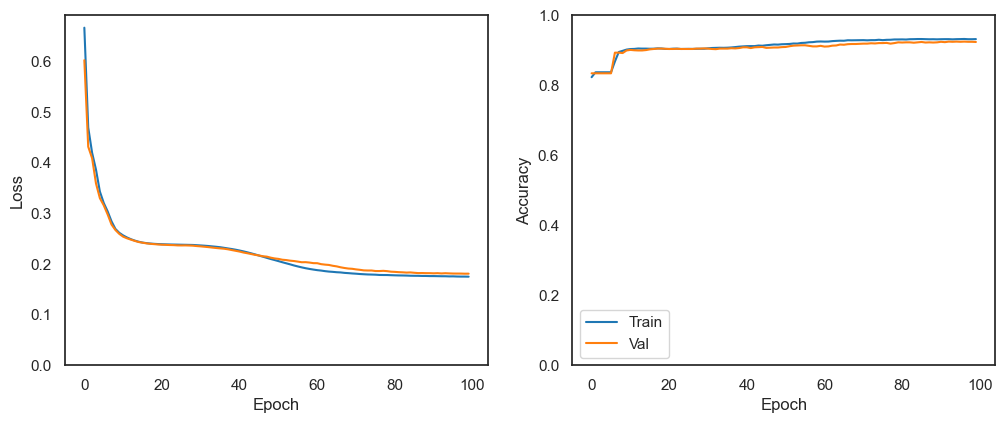

C:\Users\alexs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


dense_layers :4
batch_size :256
dense_dropout :0.0


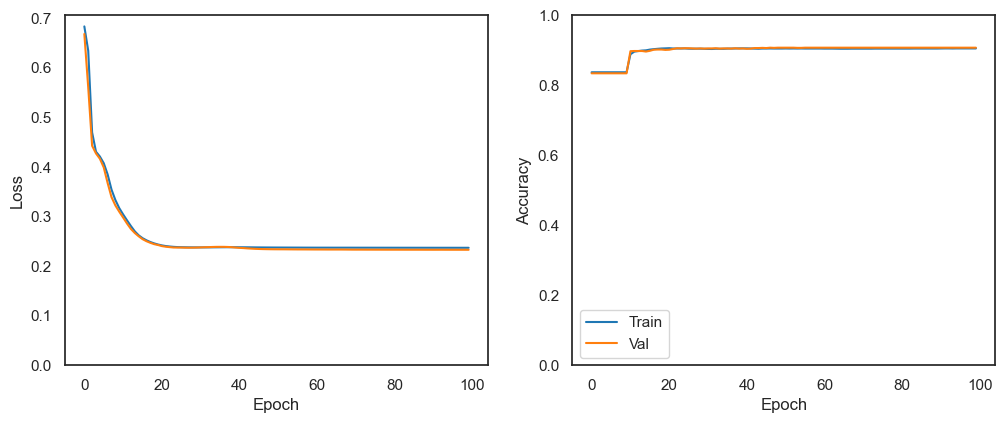

C:\Users\alexs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


dense_layers :4
batch_size :384
dense_dropout :0.0


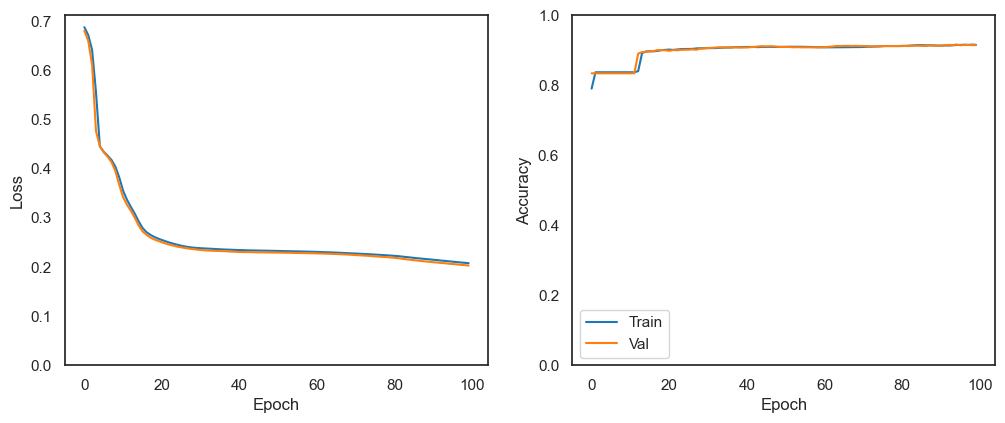

In [85]:
# Grid Search

epochs = [100]
batch_size = [128, 256, 384]
dense_layers = [4]
dense_dropout = [0.0]


param_grid = dict(dense_layers = dense_layers,
                  batch_size = batch_size,
                  epochs = epochs,
                  dense_dropout = dense_dropout)

keys = param_grid.keys()
values = (param_grid[key] for key in keys)
param_grid = [dict(zip(keys, param_grid)) for param_grid in itertools.product(*values)]

for j in range(0, len(param_grid)):
    
    dense_layers = param_grid[j].get("dense_layers")
    batch_size = param_grid[j].get("batch_size")
    dense_dropout = param_grid[j].get("dense_dropout")
    epochs = param_grid[j].get("epochs")
    
    model = make_model_2(units = units,
                         input_dim = input_dim,
                         dense_layers = dense_layers,
                         dense_dropout = dense_dropout)
    
    print('dense_layers :' + str(dense_layers))
    print('batch_size :' + str(batch_size))
    print('dense_dropout :' + str(dense_dropout))
    
    history = model.fit(train_features,
                    train_labels,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_data = (val_features, val_labels),
                    verbose = 0)
    
    
    plot_history(history)
    
    val_accuracy = pd.DataFrame.from_dict(history.history)['val_accuracy'].iloc[-1]
    val_accuracy = pd.DataFrame.from_dict(history.history)['accuracy'].iloc[-1]
    param_grid[j].update( {"val_accuracy" : val_accuracy})
    param_grid[j].update( {"val_accuracy" : val_accuracy})
    
results = pd.DataFrame(param_grid)

Ahora bien, el batch size que proporciona el mejor desempeño es el de 128.

In [86]:
results.sort_values(by=['val_accuracy'], ascending=False)

,dense_layers,batch_size,epochs,dense_dropout,val_accuracy
0,4,128,100,0.0,0.931882
2,4,384,100,0.0,0.915555
1,4,256,100,0.0,0.905197


Por ultimo se optimiza el dropout

C:\Users\alexs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


dense_layers :4
batch_size :128
dense_dropout :0


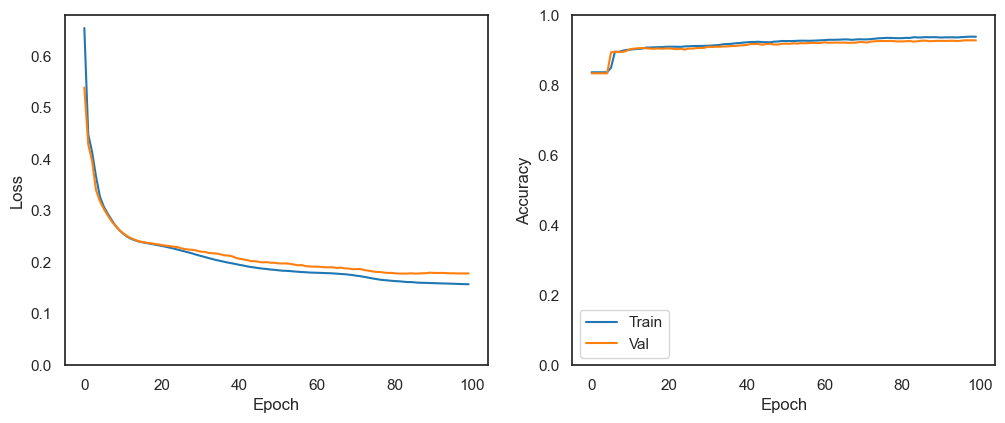

C:\Users\alexs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


dense_layers :4
batch_size :128
dense_dropout :0.05


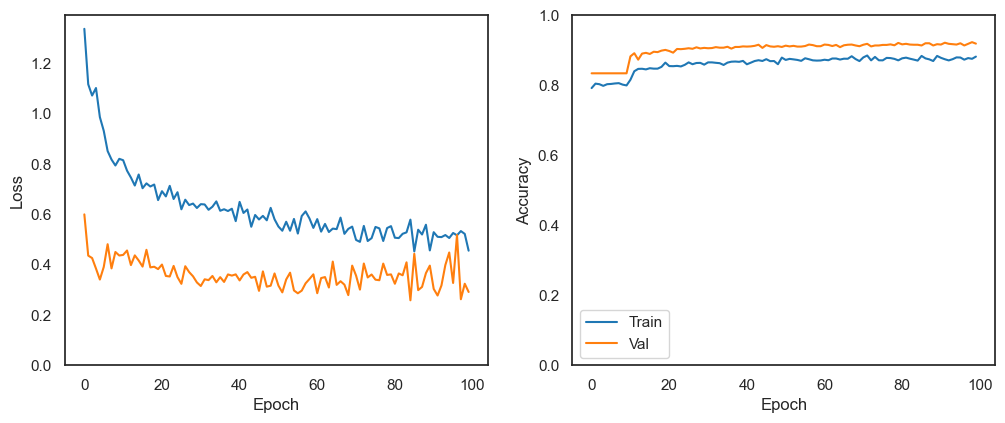

C:\Users\alexs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


dense_layers :4
batch_size :128
dense_dropout :0.1


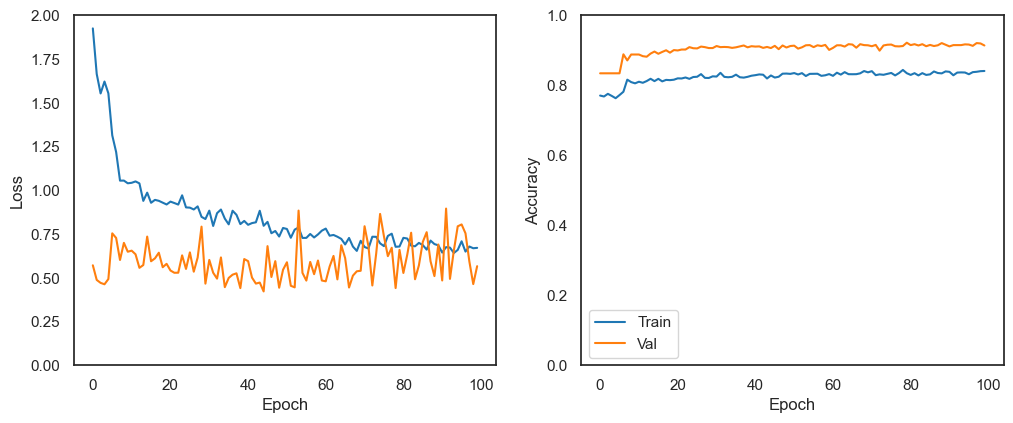

In [87]:
# Grid Search

epochs = [100]
batch_size = [128]
dense_layers = [4]
dense_dropout = [0, 0.05, 0.1]


param_grid = dict(dense_layers = dense_layers,
                  batch_size = batch_size,
                  epochs = epochs,
                  dense_dropout = dense_dropout)

keys = param_grid.keys()
values = (param_grid[key] for key in keys)
param_grid = [dict(zip(keys, param_grid)) for param_grid in itertools.product(*values)]

for j in range(0, len(param_grid)):
    
    dense_layers = param_grid[j].get("dense_layers")
    batch_size = param_grid[j].get("batch_size")
    dense_dropout = param_grid[j].get("dense_dropout")
    epochs = param_grid[j].get("epochs")
    
    model = make_model_2(units = units,
                         input_dim = input_dim,
                         dense_layers = dense_layers,
                         dense_dropout = dense_dropout)
    
    print('dense_layers :' + str(dense_layers))
    print('batch_size :' + str(batch_size))
    print('dense_dropout :' + str(dense_dropout))
    
    history = model.fit(train_features,
                    train_labels,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_data = (val_features, val_labels),
                    verbose = 0)
    
    
    plot_history(history)
    
    val_accuracy = pd.DataFrame.from_dict(history.history)['val_accuracy'].iloc[-1]
    val_accuracy = pd.DataFrame.from_dict(history.history)['accuracy'].iloc[-1]
    param_grid[j].update( {"val_accuracy" : val_accuracy})
    param_grid[j].update( {"val_accuracy" : val_accuracy})
    
results = pd.DataFrame(param_grid)

Se puede ver que no hacer dropout en este caso da el mejor desempeño, con un valor de accuracy del 93%. 

In [88]:
results.sort_values(by=['val_accuracy'], ascending=False)

,dense_layers,batch_size,epochs,dense_dropout,val_accuracy
0,4,128,100,0.00,0.938553
1,4,128,100,0.05,0.881847
2,4,128,100,0.10,0.840765


Se escoge la arquitectura 1 la cual tiene un 94% de accuracy, frente a la arquitectura 2 con un accruacy del 93%. Se considera la arquitectura 1 es más robusta ante el sobreajuste, según evidencian los gráficos de perdida analizados en ambas arquitecturas.

### 06 - Evaluate Choosen model

Ahora bien, se procede a evaluar el modelo escogido con el set de validación y de prueba.

In [65]:
epochs = 100
batch_size = 256
dense_layers = 4
dense_dropout = 0.05


model = make_model_1(units = units,
                     input_dim = input_dim,
                     dense_layers = dense_layers,
                     dense_dropout = dense_dropout)
    
history = model.fit(train_features,
                    train_labels,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_data = (val_features, val_labels), 
                    verbose = 0)


C:\Users\alexs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



    1.  En el set de validación se predice correctamente cuando un cliente no se da de baja el 82% de los casos, y 96% de los casos que si se dan de baja 
    2. En el set de prueba se predice correctamente cuando un cliente no se da de baja el 77% de los casos, y 95% de los casos que si se dan de baja
    3. Se tiene un accruacy del 92% en el set de prueba. 

In [66]:
val_accuracy = pd.DataFrame.from_dict(history.history)['val_accuracy'].iloc[-1]
print(val_accuracy)

0.9352290630340576


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


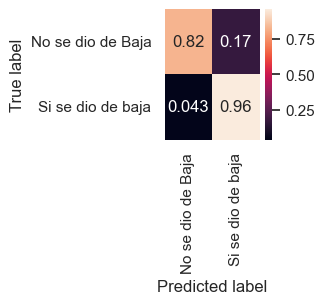

In [67]:
classes = {'No se dio de Baja':1, 'Si se dio de baja':0}
y_pred = model.predict(val_features)
y_pred = np.argmax(y_pred, axis=1)
plot_confussion_matrix(labels = val_labels, predictions = y_pred, classes = classes, figsize = 3)

In [69]:
y_pred = model.predict(test_features)
y_pred = np.argmax(y_pred, axis=1)

print(accuracy_score(test_labels, y_pred))

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
0.9249605055292259


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


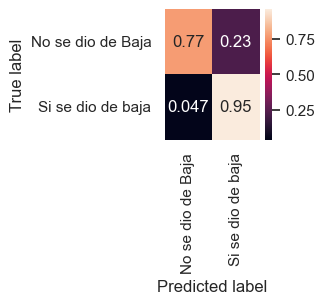

In [68]:
classes = {'No se dio de Baja':1, 'Si se dio de baja':0}
plot_confussion_matrix(labels = test_labels, predictions = y_pred, classes = classes, figsize = 3)

### 07 - Feature Engineering

Como propuesta de Feature Engineering se calcula la cantidad tranferida media por cada transacción relizada utilizando la cantidad total transferida (total_trans_amt) y el numero de transacciones (total_trans_ct).

In [115]:
raw_data["total_trans_amt_por_trans_ct"] = raw_data["total_trans_amt"]/raw_data["total_trans_ct"]

In [116]:
raw_data.head()

,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,...,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,total_trans_amt_por_trans_ct
0,1,45,M,3,1,Married,2,0,39,5,...,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,27.238095
1,1,49,F,5,3,Single,0,0,44,6,...,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,39.121212
2,1,51,M,3,3,Married,3,0,36,4,...,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,94.350000
3,1,40,F,4,1,Married,0,0,34,3,...,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,58.550000
4,1,40,M,3,0,Married,2,0,21,5,...,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,29.142857


In [117]:
# Prepare data for modelling

data = raw_data.copy()

# Normalizar columnas numericas
columnas_a_normalizar = data.select_dtypes(include=['number']).columns

for col_name in columnas_a_normalizar:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(data[col_name].values.reshape(-1, 1))
    data[col_name] = scaler.transform(data[col_name].values.reshape(-1, 1))
    


# Pasar a dummy las variables categoricas

dummed_features = []

for col_name in data.columns:
    
    if(data[col_name].dtype == 'object' and col_name != 'attrition_flag'):
        j = pd.get_dummies(data[col_name], dtype=int)
        data = pd.concat([data, j], axis=1)
        dummed_features.append(col_name)

# remove all transformed features
data = data[data.columns.difference(dummed_features)]


data['attrition_flag'] = data['attrition_flag'].astype(int)

# Separar data en train y test

train_df, test_df = train_test_split(data, test_size = 0.25, random_state = 0)

train_df, val_df = train_test_split(train_df, test_size = 0.25, random_state = 0)



target = "attrition_flag"

# Extraer X
train_features = np.array(train_df[train_df.columns.difference([target])])
val_features = np.array(val_df[val_df.columns.difference([target])])
test_features = np.array(test_df[test_df.columns.difference([target])])

# Extraer Y
train_labels = np.array(train_df[[target]])
val_labels = np.array(val_df[[target]])
test_labels = np.array(test_df[[target]])

# Definir variable utiles para la red neuronal
units = train_features.shape[1]
input_dim = train_features.shape[1]




Se procede a utilizar el mejor modelo encontrado con este nuevo cambio

In [118]:
# Model

epochs = 100
batch_size = 256
dense_layers = 4
dense_dropout = 0.05


model = make_model_1(units = units,
                     input_dim = input_dim,
                     dense_layers = dense_layers,
                     dense_dropout = dense_dropout)
    
history = model.fit(train_features,
                    train_labels,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_data = (val_features, val_labels), 
                    verbose = 0)



C:\Users\alexs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


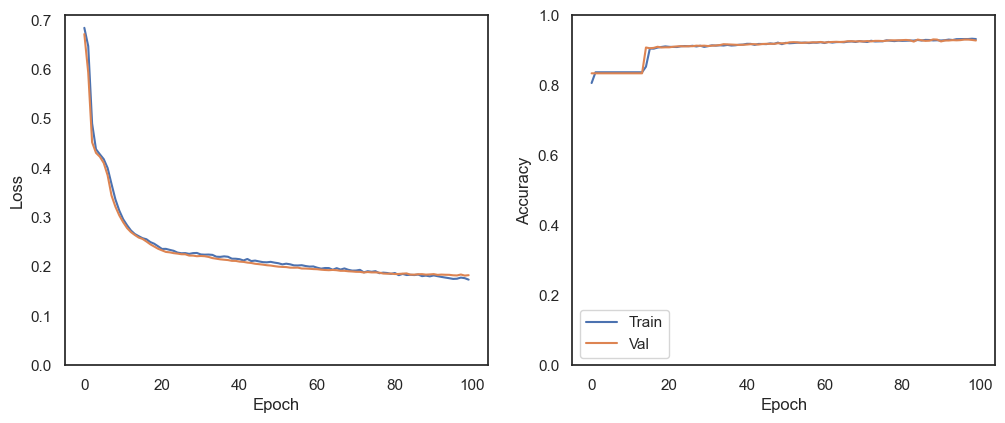

In [119]:
plot_history(history)

    1. Se obtiene un accuracy del 92% en el set de validación y en el set de prueba  
    2. En el set de validación se predice correctamente cuando un cliente no se da de baja el 66% de los casos, y 98% de los casos que si se dan de baja 
    3. En el set de prueba se predice correctamente cuando un cliente no se da de baja el 66% de los casos, y 97% de los casos que si se dan de baja

In [120]:
val_accuracy = pd.DataFrame.from_dict(history.history)['val_accuracy'].iloc[-1]
print(val_accuracy)

0.9278567433357239


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


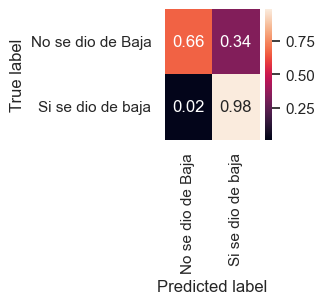

In [121]:
classes = {'No se dio de Baja':1, 'Si se dio de baja':0}
y_pred = model.predict(val_features)
y_pred = np.argmax(y_pred, axis=1)
plot_confussion_matrix(labels = val_labels, predictions = y_pred, classes = classes, figsize = 3)

In [122]:
y_pred = model.predict(test_features)
y_pred = np.argmax(y_pred, axis=1)

print(accuracy_score(test_labels, y_pred))

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
0.9261453396524486


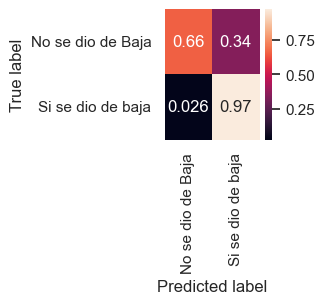

In [123]:
classes = {'No se dio de Baja':1, 'Si se dio de baja':0}
plot_confussion_matrix(labels = test_labels, predictions = y_pred, classes = classes, figsize = 3)

### 08 - Conclusions 

    1. Al probar dos arquitecturas de redes neuronales alternativas para predecir la deserción de clientes al servicio de tarjetas de credito, se encuentra que la mejor arquitectura es un modelo secuencial formado por 1 capa de entrada, 4 capas ocultas, una capa de salida. Donde todas la capas ocultas tienen 22 neuronas, función de activación RELU, inicializador kernel normal y un dropout de 0.05. La capa de salida tiene 2 neuronas, función de activación softmax, e inicilizador kernel uniforme. Donde se utiliza el optimizador de Adam, y como función de perdida se utiliza Sparse Categorical Crossentropy. El modelo es entrenado con 100 epochs y batch size de 256. 
    
    2. La architectura escogida obtiene un 94% y 92% de accuracy en el set de entrenamiento y prueba respectivamente. En el set de validación se predice correctamente cuando un cliente no se da de baja el 82% de los casos, y 96% de los casos que si se dan de baja. Mientreas en en el set de prueba se predice correctamente cuando un cliente no se da de baja el 77% de los casos, y 95% de los casos que si se dan de baja.
    
    3. Al realizar Feature Engieneering y agregar la variable Transferencia media por transacción, se obtiene un accuracy del 92% en el set de validación y en el set de prueba. Sin embargo, en el set de validación se predice correctamente cuando un cliente no se da de baja el 66% de los casos, y 98% de los casos que si se dan de baja. Por otro lado, en el set de prueba se predice correctamente cuando un cliente no se da de baja el 66% de los casos, y 97% de los casos que si se dan de baja.
    
    4. Por lo tanto, al bajar la predicción correcta cuando un cliente no se da de baja de un 77% a un 66% en el set de prueba, se concluye que el modelo sin la variable Transferencia media por transacción es mejor